### Further clean BALANCE variables (round to 2 decimals / integerize / ...)

In [1]:
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import random
import sys
sys.path.append("../../")
import time
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
from pandarallel import pandarallel
from tqdm import tqdm

In [2]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [3]:
from utils.common import *
from utils.constants import *
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, print_percentile,
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number, plot_sampled_time_series, describe_all, check_psi, plot_heatmap, filter_df
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, check_roc_auc,
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS
)
from utils.preprocess_helpers import *

In [4]:
%load_ext autoreload
%autoreload

In [5]:
gc.collect()

18

In [6]:
START = time.time()

### Setup

In [7]:
%%time
train = read_file(f"../{RAW_TRAIN_PARQUET_PATH}/balance.parquet")
test = read_file(f"../{RAW_TEST_PARQUET_PATH}/balance.parquet")

Shape of data: (5531451, 42)
Shape of data: (11363762, 42)
CPU times: user 21.4 s, sys: 36.6 s, total: 57.9 s
Wall time: 32.3 s


In [8]:
%%time
labels = pd.read_csv(f"../{RAW_DATA_PATH}/train_labels.csv")
if "target" not in train.columns:
    train = train.merge(labels, on="customer_ID", how="left")

CPU times: user 2.2 s, sys: 2.54 s, total: 4.74 s
Wall time: 7.17 s


In [9]:
%%time
public_test, private_test = split_public_private(test)

Public size: 5719469, Private size: 5644293
CPU times: user 6.31 s, sys: 2.42 s, total: 8.73 s
Wall time: 8.98 s


In [10]:
del test

In [11]:
train.shape, public_test.shape, private_test.shape

((5531451, 43), (5719469, 42), (5644293, 42))

In [12]:
df_list = [train, public_test, private_test]

In [13]:
print(sorted(get_cols(train, ["B_"])))

['B_1', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_2', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_27', 'B_28', 'B_29', 'B_3', 'B_30', 'B_31', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_39', 'B_4', 'B_40', 'B_41', 'B_42', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9']


In [14]:
train["target"].mean()

0.24909720794778803

In [15]:
for df in df_list:
    insert_row_number(df)

Done insertion
Done insertion
Done insertion


In [16]:
pandarallel.initialize(nb_workers=12, progress_bar=False, use_memory_fs=False)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [17]:
# train_corr = read_file(f"../{RAW_DATA_PATH}/pre_clean_train_balance_corr.csv")
# train_corr.index = train_corr.columns

### B_723 (Created)

In [18]:
for df in df_list:
    df["B_723"] = (df["B_7"] + df["B_23"]).round(2)
    df = clip_col(df, "B_723", top_value=2.62, add_new_col=False)
    df = clip_col(df, "B_723", btm_value=-0.03, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


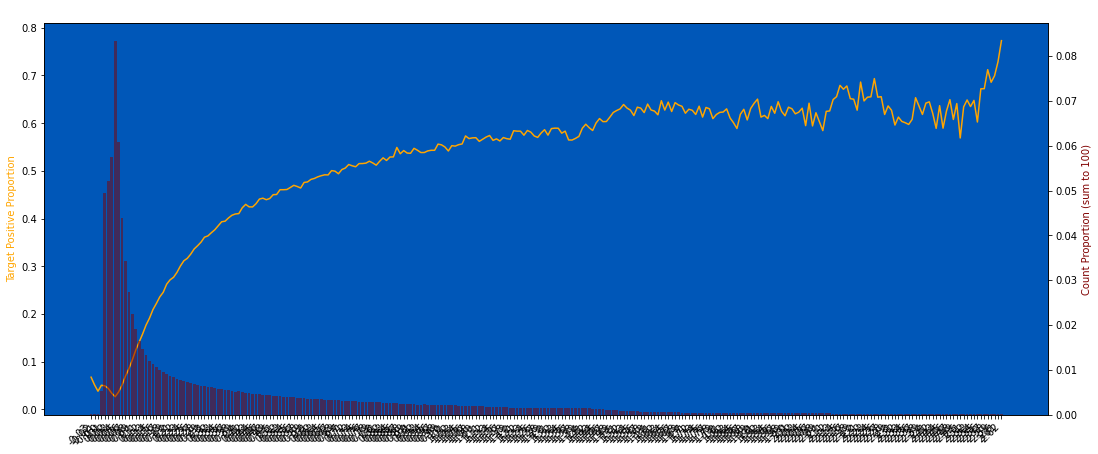

In [19]:
plot_target_check(train, "B_723", q=100, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [20]:
# print_percentile(df_list, "B_723", 0.005)
# describe_all(df_list, "B_723")

### B_111 (Created)

In [21]:
for df in df_list:
    df["B_111"] = sigmoid(df["B_1"] / df["B_11"] - 1)

In [22]:
df_list = round_dfs(df_list, col="B_111", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0028
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0025


In [23]:
for df in df_list:
    df = clip_col(df, "B_111", btm_value=0.26, add_new_col=False)

In [24]:
# print_percentile(df_list, "B_111", 0.5)

0 null count, 0.000 null proportion
nan of the targets have label = 1


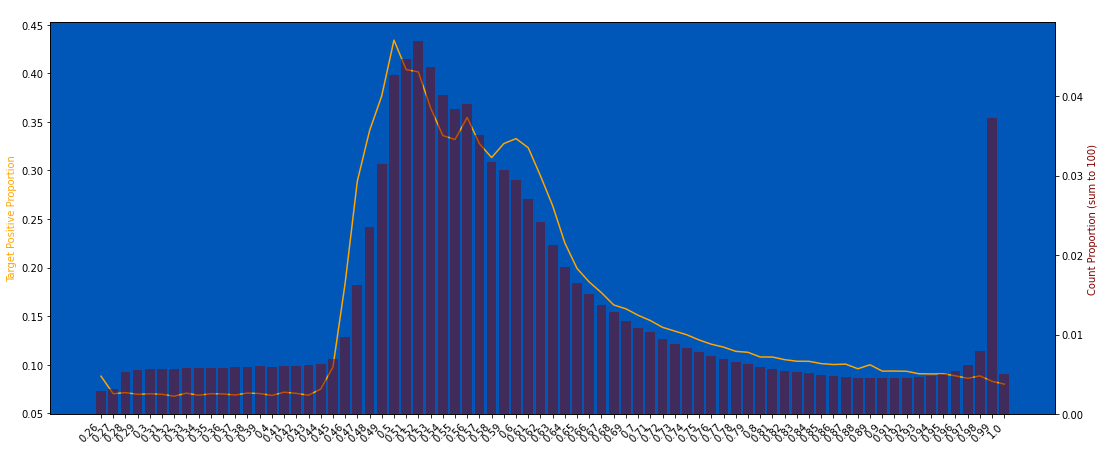

In [25]:
plot_target_check(train, "B_111", q=100, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [26]:
# plot_train_test_distribution(df_list, "B_111", nunique_thr=8000, without_drop_tail=True)

### B_137 (Created)

In [27]:
for df in df_list:
    df["B_137"] = sigmoid(df["B_1"] / df["B_37"] - 1)

In [28]:
df_list = round_dfs(df_list, col="B_137", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0025
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0021


In [29]:
for df in df_list:
    df = clip_col(df, "B_137", btm_value=0.26, add_new_col=False)
    df["B_137"] = df["B_137"].replace((1, 0.26), np.nan)

19317 null count, 0.003 null proportion
0.2099 of the targets have label = 1


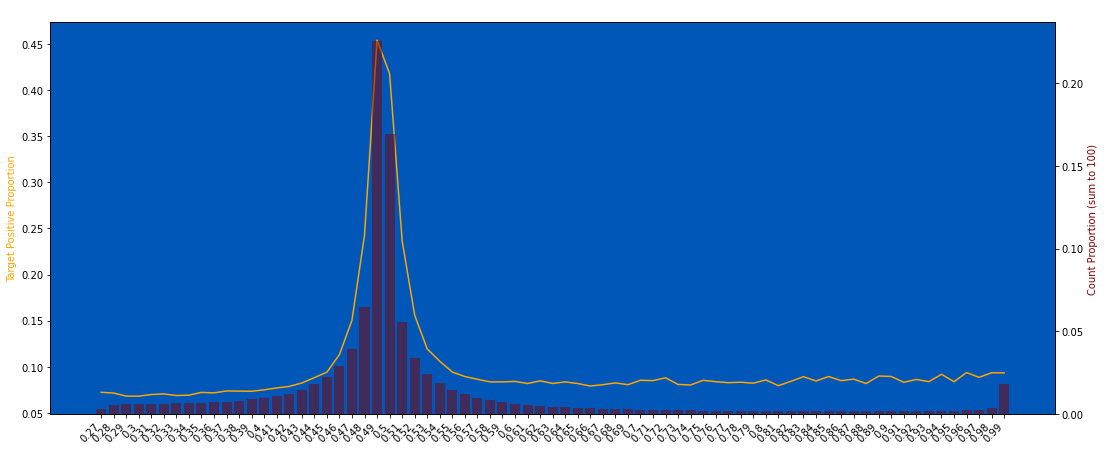

In [30]:
plot_target_check(train, "B_137", q=100, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [31]:
# plot_train_test_distribution(df_list, "B_137", nunique_thr=8000, without_drop_tail=True)

### B_1 (Done)

In [32]:
# plot_target_check(train, "B_1", q=50, use_raw_bin=True)

In [33]:
%%time
df_list = round_dfs(df_list, col="B_1", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0302
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0264
CPU times: user 4.85 s, sys: 3.09 s, total: 7.94 s
Wall time: 10.8 s


In [34]:
print_percentile(df_list, "B_1", 0.015)
describe_all(df_list, "B_1")

0.015th percentile:
train : -0.05
public test : -0.05
private test : -0.05


,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.1190,0.1252,0.1207
std,0.2120,0.2158,0.2094
min,-7.5900,-7.0600,-1.6400
25%,0.0000,0.0000,0.0000
50%,0.0300,0.0300,0.0300
75%,0.1200,0.1300,0.1300
max,1.3200,1.3200,1.3200
null_proportion,0.0000,0.0000,0.0000


In [35]:
for df in df_list:
    df = clip_col(df, "B_1", btm_value=-0.05, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


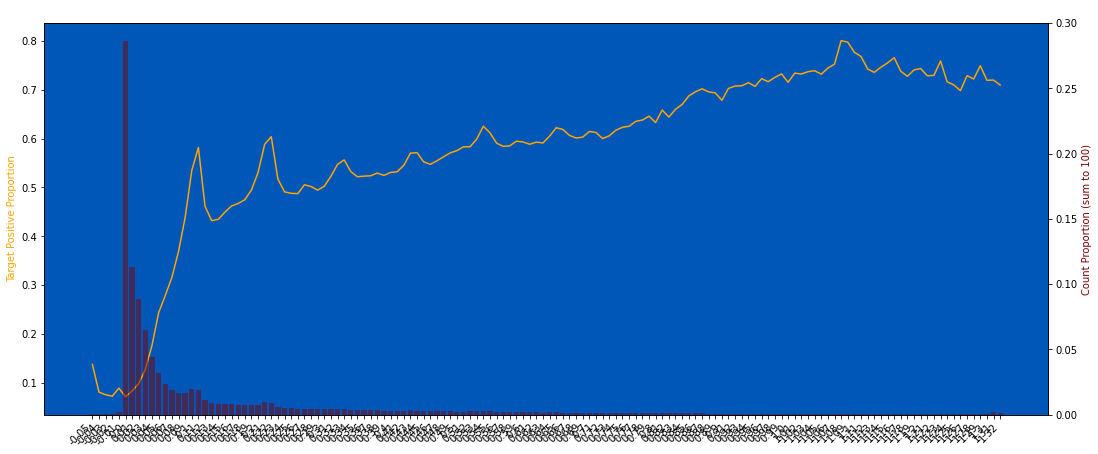

In [36]:
plot_target_check(train, "B_1", q=100, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [37]:
# plot_train_test_distribution(df_list, "B_1", nunique_thr=8000, without_drop_tail=True)

### B_2 (Done)

In [38]:
# plot_target_check(train, "B_2", q=50, use_raw_bin=True)

In [39]:
%%time
df_list = round_dfs(df_list, col="B_2", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0109
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0107
CPU times: user 4.62 s, sys: 2.73 s, total: 7.35 s
Wall time: 9.91 s


2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


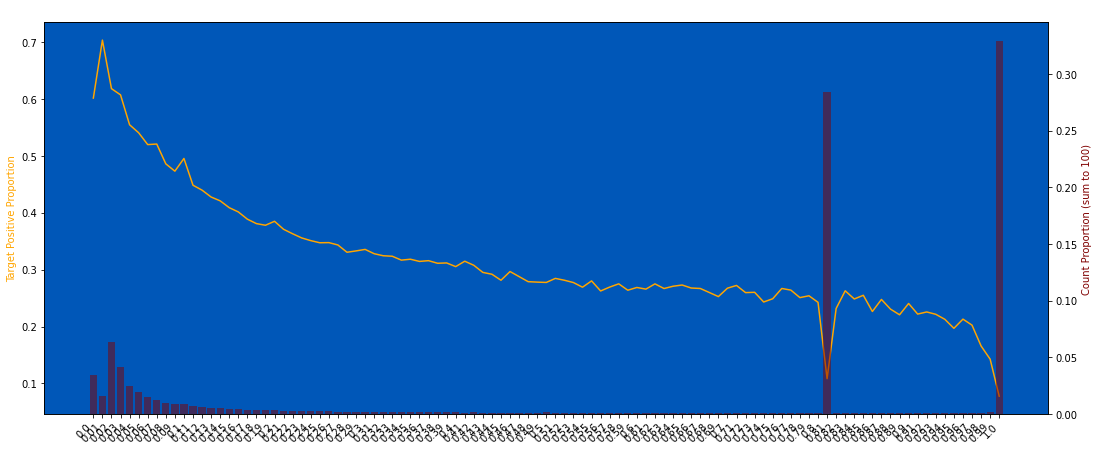

In [40]:
plot_target_check(train, "B_2", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [41]:
# plot_train_test_distribution(df_list, "B_2", nunique_thr=8000, without_drop_tail=True)

### B_3 (Done)

In [42]:
# plot_target_check(train, "B_3", q=50, use_raw_bin=True)

In [43]:
%%time
df_list = round_dfs(df_list, col="B_3", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0340
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0063
CPU times: user 4.51 s, sys: 2.26 s, total: 6.77 s
Wall time: 8.59 s


In [44]:
print_percentile(df_list, "B_3", 99.99)
describe_all(df_list, "B_3")

99.99th percentile:
train : 1.36
public test : 1.3620939999911934
private test : 1.36


,train,public test,private test
count,"5,529,435.0000","5,717,907.0000","5,642,938.0000"
mean,0.1275,0.1394,0.1374
std,0.2350,0.2459,0.2443
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0100,0.0100
75%,0.1500,0.1800,0.1700
max,1.6200,1.6900,1.6600
null_proportion,0.0004,0.0003,0.0002


In [45]:
for df in df_list:
    df = clip_col(df, "B_3", top_value=1.36, add_new_col=False)

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


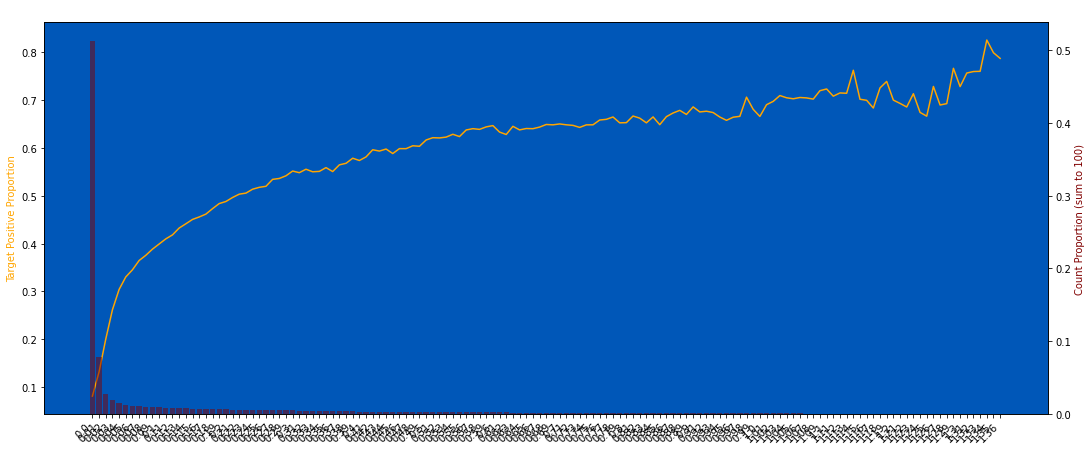

In [46]:
plot_target_check(train, "B_3", q=50, use_raw_bin=True, nunique_thr=8000, strfy_x=True, without_drop_tail=True)

In [47]:
# plot_train_test_distribution(df_list, "B_3", nunique_thr=8000)

### B_4 (Done)

In [48]:
# plot_target_check(train, "B_4", q=50, use_raw_bin=True, nunique_thr=1000)

In [49]:
%%time
df_list = round_dfs(df_list, col="B_4", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0239
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0255
CPU times: user 4.59 s, sys: 2.63 s, total: 7.23 s
Wall time: 9.49 s


In [50]:
# print_percentile(df_list, "B_4", 99.9)
# describe_all(df_list, "B_4")

In [51]:
for df in df_list:
    df = clip_col(df, "B_4", top_value=1.63, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


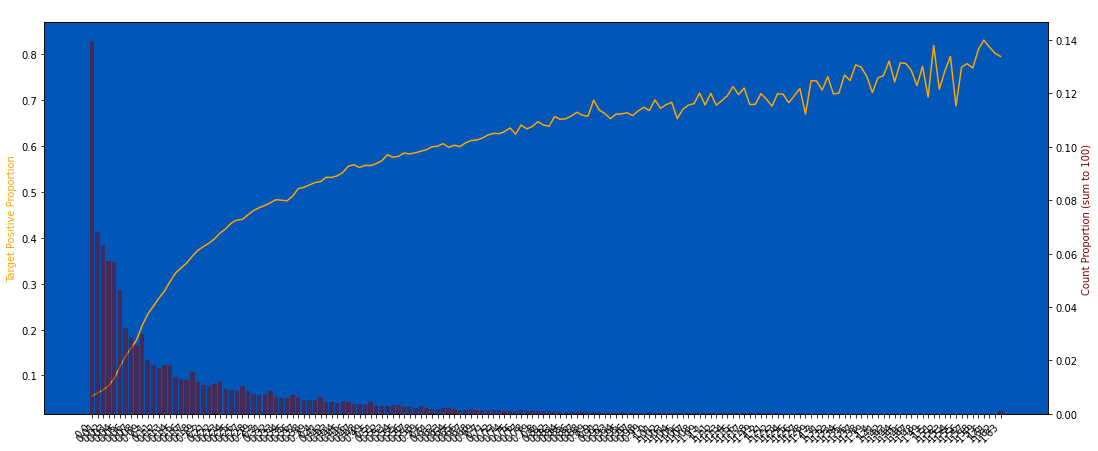

In [52]:
plot_target_check(train, "B_4", q=50, use_raw_bin=True, nunique_thr=8000, strfy_x=True)

In [53]:
# plot_train_test_distribution(df_list, "B_4", nunique_thr=8000)

### B_5 (Done)

In [54]:
# plot_target_check(train, "B_5", q=50, use_raw_bin=True)

In [55]:
%%time
df_list = round_dfs(df_list, col="B_5", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0659
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0646
CPU times: user 5.2 s, sys: 2.6 s, total: 7.8 s
Wall time: 10.1 s


In [56]:
# print_percentile(df_list, "B_5", 99)
# describe_all(df_list, "B_5")

In [57]:
for df in df_list:
    df = clip_col(df, "B_5", top_value=2, add_new_col=False)
    df["B_5"] = df["B_5"].replace(0, np.nan)

2108895 null count, 0.381 null proportion
0.2503 of the targets have label = 1


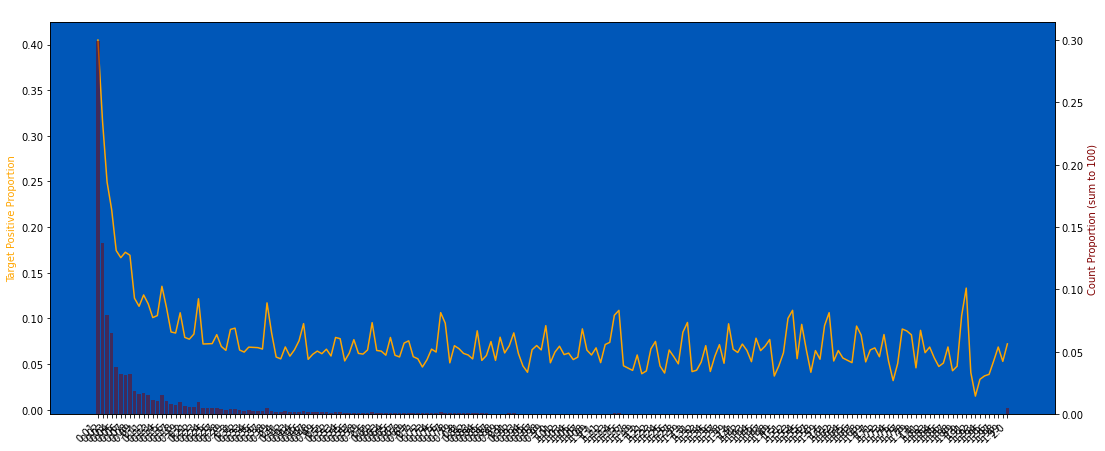

In [58]:
plot_target_check(train, "B_5", q=50, use_raw_bin=True, nunique_thr=8000, strfy_x=True)

In [59]:
# plot_train_test_distribution(df_list, "B_5", nunique_thr=8000)

### B_6 (Done)

In [60]:
%%time
df_list = round_dfs(df_list, col="B_6", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0468
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0473
CPU times: user 4.93 s, sys: 3.94 s, total: 8.87 s
Wall time: 14.2 s


In [61]:
print_percentile(df_list, "B_6", 99.5)
describe_all(df_list, "B_6")

99.5th percentile:
train : 1.7
public test : 1.83
private test : 1.92


,train,public test,private test
count,"5,531,218.0000","5,717,778.0000","5,642,910.0000"
mean,0.1471,0.1477,0.1533
std,1.4768,0.7130,0.7427
min,-0.0100,-0.0100,-0.0100
25%,0.0200,0.0200,0.0200
50%,0.0800,0.0800,0.0800
75%,0.1900,0.1900,0.1900
max,"1,214.5100",191.8400,193.3800
null_proportion,0.0000,0.0003,0.0002


In [62]:
for df in df_list:
    df = clip_col(df, "B_6", top_value=2, add_new_col=False)

233 null count, 0.000 null proportion
0.2532 of the targets have label = 1


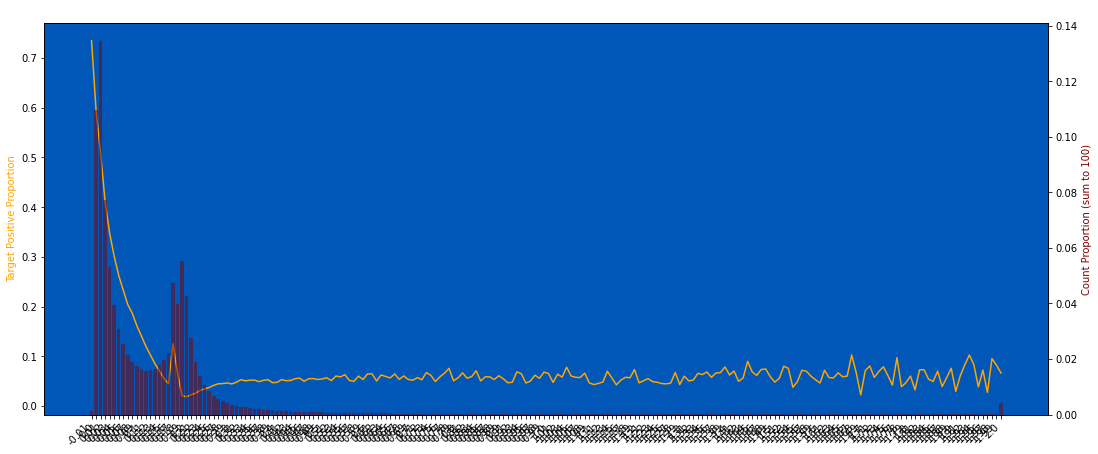

In [63]:
plot_target_check(train, "B_6", q=50, use_raw_bin=True, nunique_thr=7200, strfy_x=True)

In [64]:
# plot_train_test_distribution(df_list, "B_6", nunique_thr=8000)

### B_7 (Done)

In [65]:
# plot_target_check(train, "B_7", q=50, use_raw_bin=True)

In [66]:
%%time
df_list = round_dfs(df_list, col="B_7", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0305
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0178
CPU times: user 5.45 s, sys: 7.5 s, total: 13 s
Wall time: 22.5 s


In [67]:
print_percentile(df_list, "B_7", 0.007)
describe_all(df_list, "B_7")

0.007th percentile:
train : -0.04
public test : -0.04
private test : -0.04


,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.1811,0.1805,0.1748
std,0.2304,0.2283,0.2248
min,-2.6600,-6.6800,-1.5600
25%,0.0200,0.0200,0.0200
50%,0.0700,0.0700,0.0700
75%,0.2700,0.2700,0.2600
max,1.2500,1.2500,1.2500
null_proportion,0.0000,0.0000,0.0000


In [68]:
for df in df_list:
    df = clip_col(df, "B_7", btm_value=-0.04, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


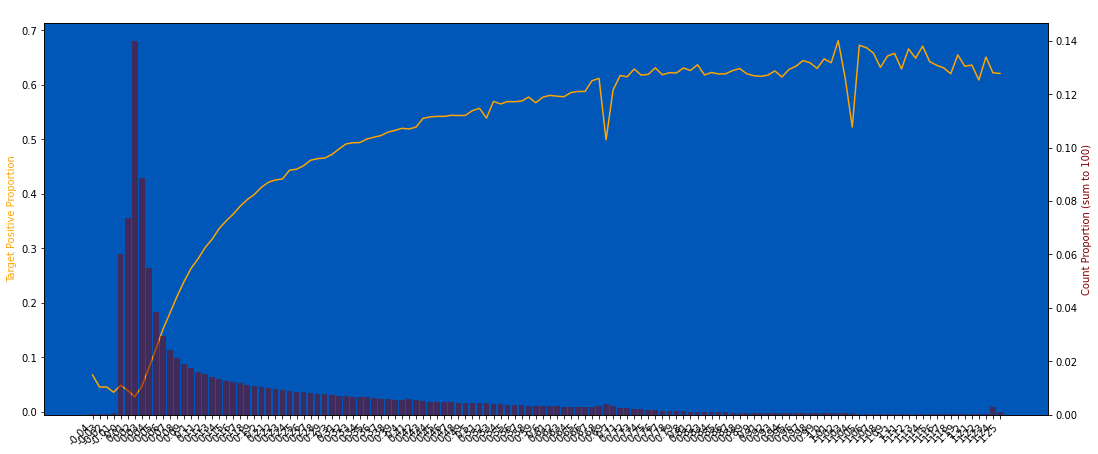

In [69]:
plot_target_check(train, "B_7", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [70]:
# plot_train_test_distribution(df_list, "B_7", nunique_thr=8000)

### B_8 (Done Binary)

In [71]:
# plot_target_check(train, "B_8", q=50, use_raw_bin=True)

In [72]:
%%time
df_list = round_dfs(df_list, col="B_8", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0073
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0061
CPU times: user 4.38 s, sys: 3.62 s, total: 8 s
Wall time: 11.7 s


In [73]:
train["B_8"].value_counts()

0.0000    3053857
1.0000    2399757
0.9900      54735
1.0100        834
Name: B_8, dtype: int64

In [74]:
train.groupby(["B_8"])["target"].mean()

B_8
0.0000   0.1233
0.9900   0.3732
1.0000   0.4057
1.0100   0.6547
Name: target, dtype: float64

In [75]:
for df in df_list:
    df["B_8"] = df["B_8"].round(0)

22268 null count, 0.004 null proportion
0.3044 of the targets have label = 1


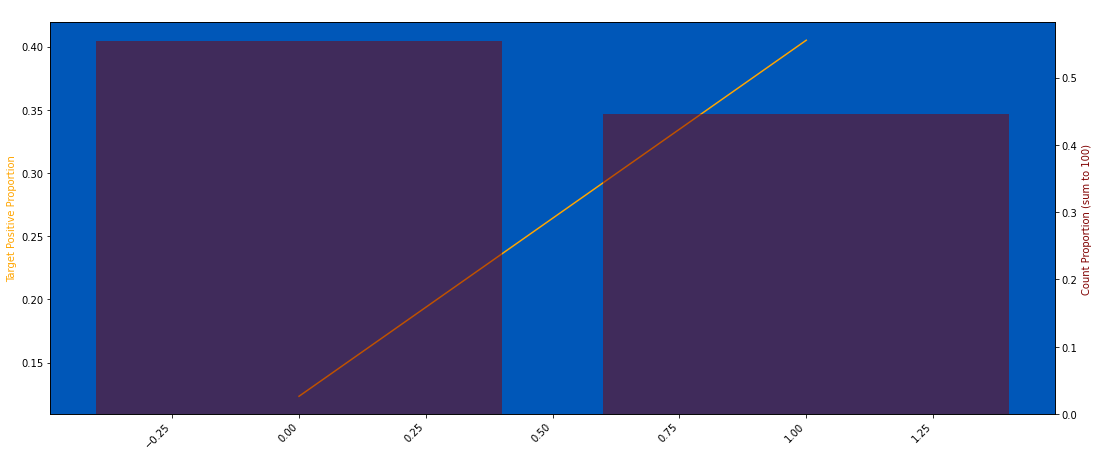

In [76]:
plot_target_check(train, "B_8", q=50, use_raw_bin=True)

In [77]:
# plot_train_test_distribution(df_list, "B_8", nunique_thr=8000)

### B_9 (Done)

In [78]:
# plot_target_check(train, "B_9", q=50, use_raw_bin=True)

In [79]:
%%time
df_list = round_dfs(df_list, col="B_9", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1149
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.1200
CPU times: user 4.75 s, sys: 3.79 s, total: 8.54 s
Wall time: 12.6 s


In [80]:
for df in df_list:
    df["B_9"] = df["B_9"].replace(0, np.nan)

In [81]:
print_percentile(df_list, "B_9", 99.9)
describe_all(df_list, "B_9")

99.9th percentile:
train : 2.26
public test : 2.0
private test : 1.93


,train,public test,private test
count,"3,067,816.0000","3,282,618.0000","3,255,709.0000"
mean,0.3327,0.3261,0.3120
std,0.3138,0.2985,0.2956
min,0.0100,0.0100,0.0100
25%,0.0700,0.0700,0.0600
50%,0.2800,0.2800,0.2500
75%,0.5800,0.5800,0.5700
max,27.4200,37.3700,90.6000
null_proportion,0.4454,0.4261,0.4232


In [82]:
for df in df_list:
    df = clip_col(df, "B_9", top_value=2, add_new_col=False)

2463635 null count, 0.445 null proportion
0.1038 of the targets have label = 1


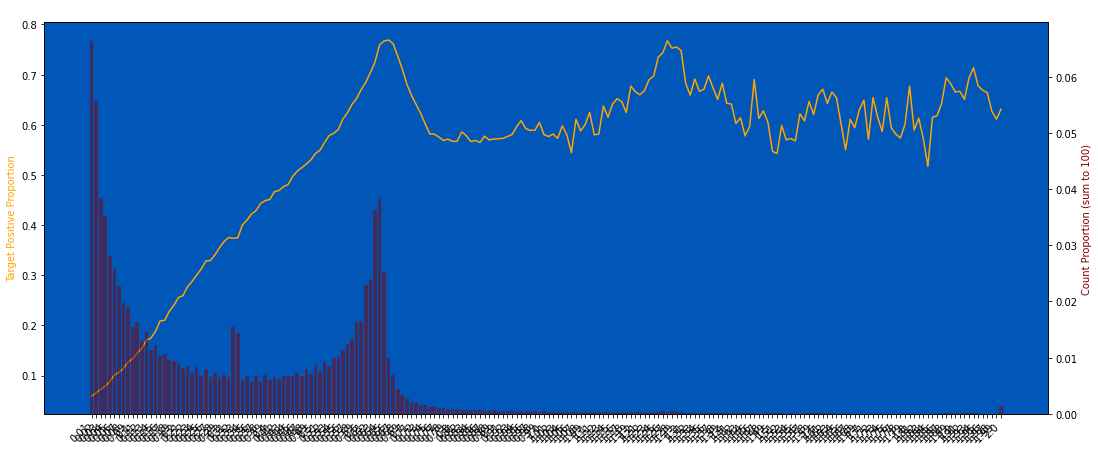

In [83]:
plot_target_check(train, "B_9", q=50, use_raw_bin=True, nunique_thr=3000, strfy_x=True)

In [84]:
# plot_train_test_distribution(df_list, "B_9", nunique_thr=8000)

### B_10 (Done)

In [85]:
# plot_target_check(train, "B_10", q=50, use_raw_bin=True)

In [86]:
%%time
df_list = round_dfs(df_list, col="B_10", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0669
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0669
CPU times: user 5.04 s, sys: 5.44 s, total: 10.5 s
Wall time: 16.2 s


In [87]:
print_percentile(df_list, "B_10", 96)
describe_all(df_list, "B_10")

96th percentile:
train : 0.33
public test : 0.37
private test : 0.4


,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.2266,0.2412,0.2550
std,4.7998,5.3091,5.7670
min,-0.0100,-0.0100,-0.0100
25%,0.0200,0.0200,0.0200
50%,0.1100,0.1100,0.1200
75%,0.2900,0.2900,0.2900
max,"4,097.4400","4,660.3500","4,345.8500"
null_proportion,0.0000,0.0000,0.0000


In [88]:
for df in df_list:
    df = clip_col(df, "B_10", top_value=1, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


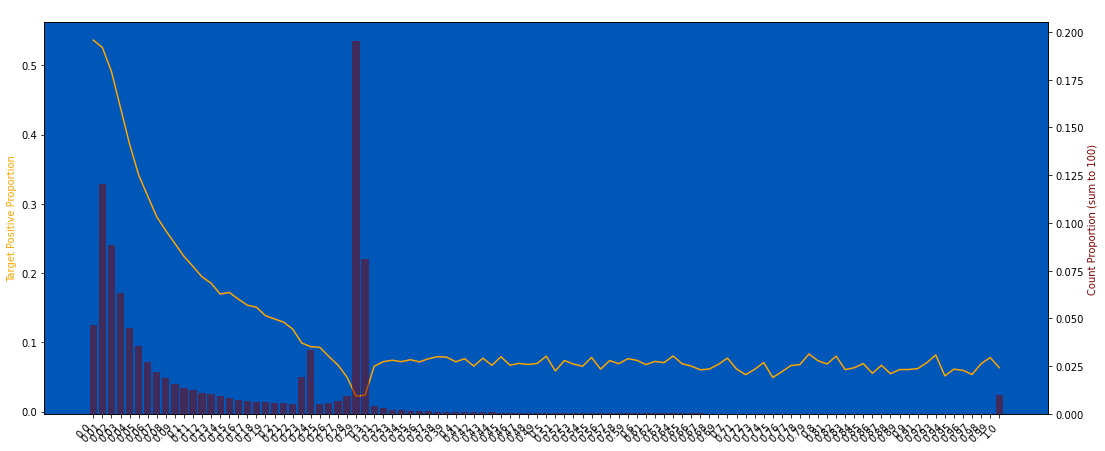

In [89]:
plot_target_check(train, "B_10", q=50, use_raw_bin=True, nunique_thr=7000, strfy_x=True, without_drop_tail=False)

In [90]:
# plot_train_test_distribution(df_list, "B_10", nunique_thr=8000)

### B_11 (Done)

In [91]:
# plot_target_check(train, "B_11", q=50, use_raw_bin=True)

In [92]:
%%time
df_list = round_dfs(df_list, col="B_11", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0198
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0075
CPU times: user 4.75 s, sys: 4.8 s, total: 9.55 s
Wall time: 14.5 s


In [93]:
print_percentile(df_list, "B_11", 99.9)
describe_all(df_list, "B_11")

99.9th percentile:
train : 1.36
public test : 1.36
private test : 1.36


,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.1060,0.1122,0.1080
std,0.2083,0.2127,0.2065
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0100,0.0200,0.0200
75%,0.1000,0.1100,0.1000
max,1.9700,1.8500,1.9400
null_proportion,0.0000,0.0000,0.0000


In [94]:
for df in df_list:
    df = clip_col(df, "B_11", top_value=1.36, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


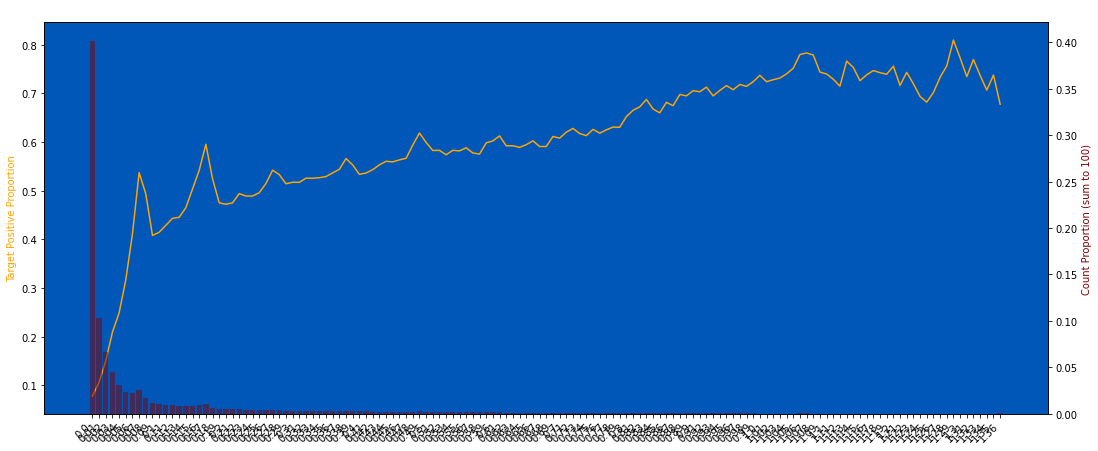

In [95]:
plot_target_check(train, "B_11", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [96]:
# plot_train_test_distribution(df_list, "B_11", nunique_thr=8000)

### B_12 (Done)

In [97]:
# plot_target_check(train, "B_12", q=50, use_raw_bin=True)

In [98]:
%%time
df_list = round_dfs(df_list, col="B_12", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0545
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0545
CPU times: user 4.29 s, sys: 2.53 s, total: 6.82 s
Wall time: 10.2 s


In [99]:
print_percentile(df_list, "B_12", 99.5)
describe_all(df_list, "B_12")

99.5th percentile:
train : 1.61
public test : 1.75
private test : 1.93


,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.0887,0.0948,0.1030
std,0.8204,0.5928,0.6029
min,0.0000,0.0000,0.0000
25%,0.0100,0.0100,0.0100
50%,0.0100,0.0200,0.0200
75%,0.0600,0.0700,0.0800
max,420.7400,192.6800,205.2900
null_proportion,0.0000,0.0000,0.0000


In [100]:
for df in df_list:
    df = clip_col(df, "B_12", top_value=1, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


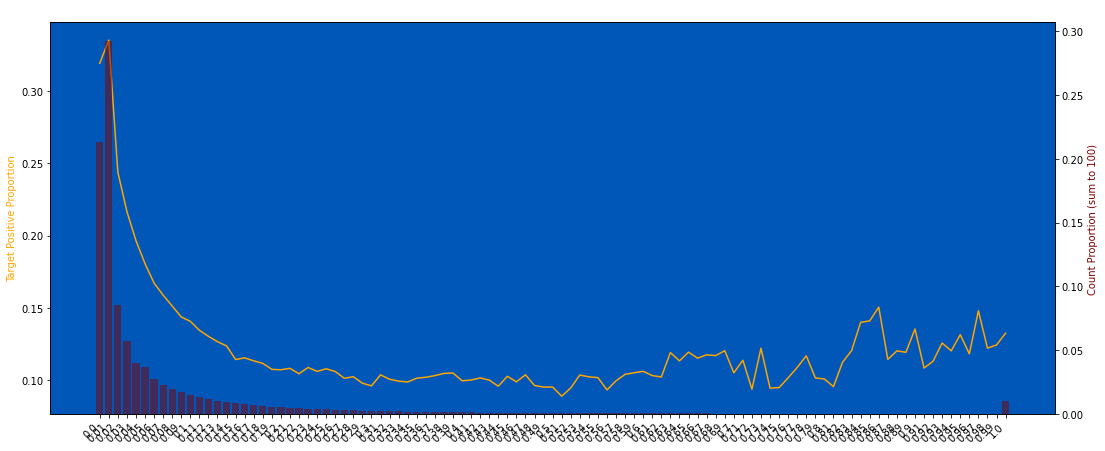

In [101]:
plot_target_check(train, "B_12", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [102]:
# plot_train_test_distribution(df_list, "B_12", nunique_thr=8000)

### B_13 (Done)

In [103]:
# plot_target_check(train, "B_13", q=50, use_raw_bin=True)

In [104]:
%%time
df_list = round_dfs(df_list, col="B_13", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0506
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0492
CPU times: user 4.28 s, sys: 4.38 s, total: 8.66 s
Wall time: 13.9 s


In [105]:
print_percentile(df_list, "B_13", 99.9)
describe_all(df_list, "B_13")

99.9th percentile:
train : 4.47
public test : 4.67
private test : 5.13


,train,public test,private test
count,"5,481,932.0000","5,685,813.0000","5,619,491.0000"
mean,0.0957,0.1026,0.1091
std,0.5594,0.5719,0.5029
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0100
50%,0.0200,0.0300,0.0300
75%,0.0800,0.0900,0.1000
max,276.1700,261.5500,143.1100
null_proportion,0.0090,0.0059,0.0044


In [106]:
for df in df_list:
    df = clip_col(df, "B_13", top_value=1, add_new_col=False)

49519 null count, 0.009 null proportion
0.4906 of the targets have label = 1


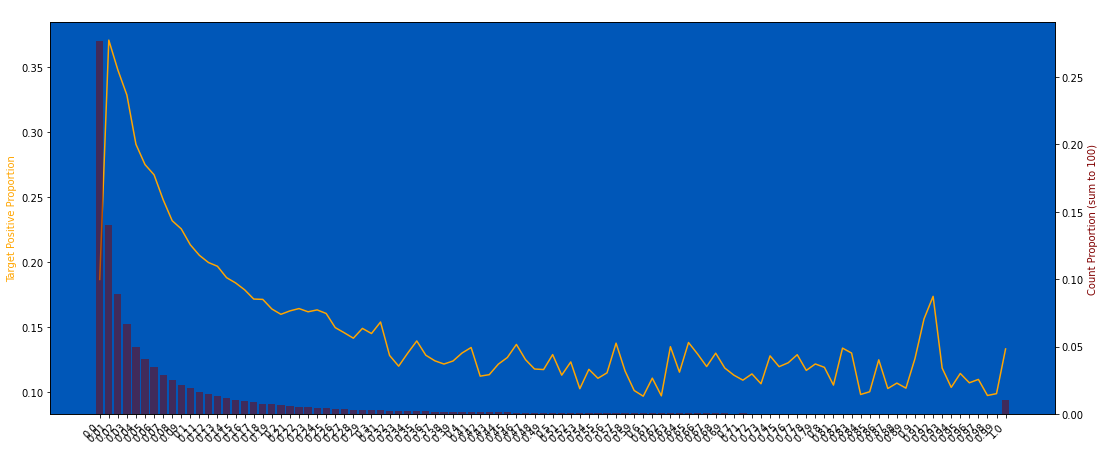

In [107]:
plot_target_check(train, "B_13", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [108]:
# plot_train_test_distribution(df_list, "B_13", nunique_thr=8000)

### B_14 (Done)

In [109]:
# plot_target_check(train, "B_14", q=50, use_raw_bin=True)

In [110]:
%%time
df_list = round_dfs(df_list, col="B_14", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0929
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0936
CPU times: user 4.46 s, sys: 2.78 s, total: 7.24 s
Wall time: 10.1 s


In [111]:
print_percentile(df_list, "B_14", 99)
describe_all(df_list, "B_14")

99th percentile:
train : 1.0
public test : 1.05
private test : 1.08


,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.0962,0.1041,0.1073
std,0.2836,0.2831,0.2903
min,-8.4700,-18.0000,-32.2300
25%,0.0000,0.0000,0.0000
50%,0.0200,0.0300,0.0300
75%,0.1000,0.1100,0.1100
max,55.0100,60.2300,32.4200
null_proportion,0.0000,0.0000,0.0000


In [112]:
for df in df_list:
    df = clip_col(df, "B_14", btm_value=-0.05, add_new_col=False)
    df = clip_col(df, "B_14", top_value=1, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


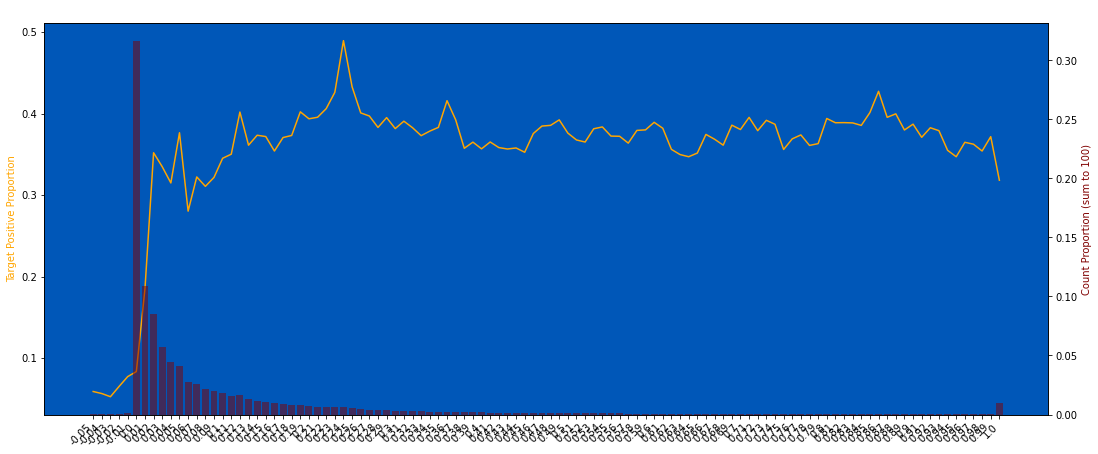

In [113]:
plot_target_check(train, "B_14", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [114]:
# plot_train_test_distribution(df_list, "B_14", nunique_thr=8000, without_drop_tail=True)

### B_15 (Done)

In [115]:
# plot_target_check(train, "B_15", q=50, use_raw_bin=True)

In [116]:
%%time
df_list = round_dfs(df_list, col="B_15", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0823
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0835
CPU times: user 4.25 s, sys: 2.38 s, total: 6.62 s
Wall time: 9.18 s


In [117]:
print_percentile(df_list, "B_15", 99.5)
describe_all(df_list, "B_15")

99.5th percentile:
train : 1.4
public test : 1.43
private test : 1.49


,train,public test,private test
count,"5,524,528.0000","5,710,673.0000","5,638,316.0000"
mean,0.0478,0.0492,0.0520
std,0.3005,0.2956,0.3021
min,-10.0100,-21.2800,-38.1000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000
max,65.0300,71.2100,38.3300
null_proportion,0.0013,0.0015,0.0011


In [118]:
for df in df_list:
    df = clip_col(df, "B_15", btm_value=-0.1, add_new_col=False)
    df = clip_col(df, "B_15", top_value=2, add_new_col=False)

6923 null count, 0.001 null proportion
0.0858 of the targets have label = 1


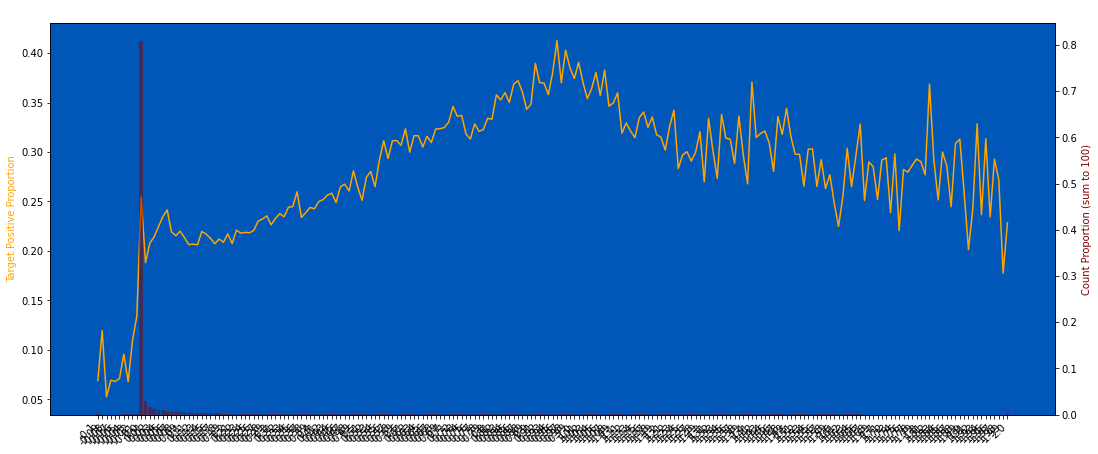

In [119]:
plot_target_check(train, "B_15", q=50, use_raw_bin=True, nunique_thr=3000, strfy_x=True, without_drop_tail=True)

In [120]:
# plot_train_test_distribution(df_list, "B_15", nunique_thr=8000, without_drop_tail=True)

### B_16 (Done Integer)

In [121]:
# plot_target_check(train, "B_16", q=50, use_raw_bin=True)

In [122]:
%%time
df_list = round_dfs(df_list, col="B_16", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0040
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0040
CPU times: user 4.15 s, sys: 1.98 s, total: 6.12 s
Wall time: 8.27 s


In [123]:
for df in df_list:
    df["B_16"] = (df["B_16"] / 0.083).round(0)

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


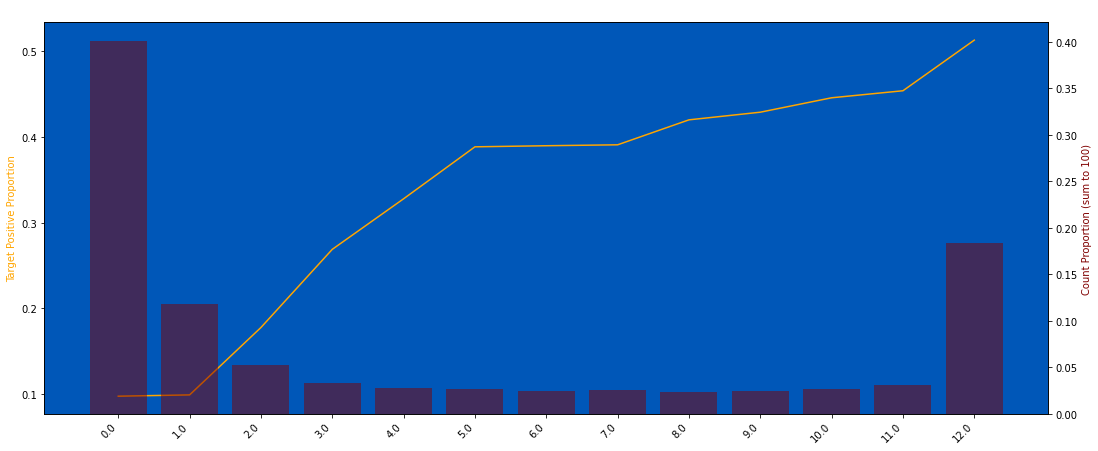

In [124]:
plot_target_check(train, "B_16", q=50, use_raw_bin=True, nunique_thr=3000, strfy_x=True, without_drop_tail=True)

In [125]:
# plot_train_test_distribution(df_list, "B_16", nunique_thr=8000)

### B_17 (Done)

In [126]:
# plot_target_check(train, "B_17", q=50, use_raw_bin=True)

In [127]:
%%time
df_list = round_dfs(df_list, col="B_17", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0044
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0040
CPU times: user 3.91 s, sys: 3.54 s, total: 7.44 s
Wall time: 11.3 s


3137598 null count, 0.567 null proportion
0.1226 of the targets have label = 1


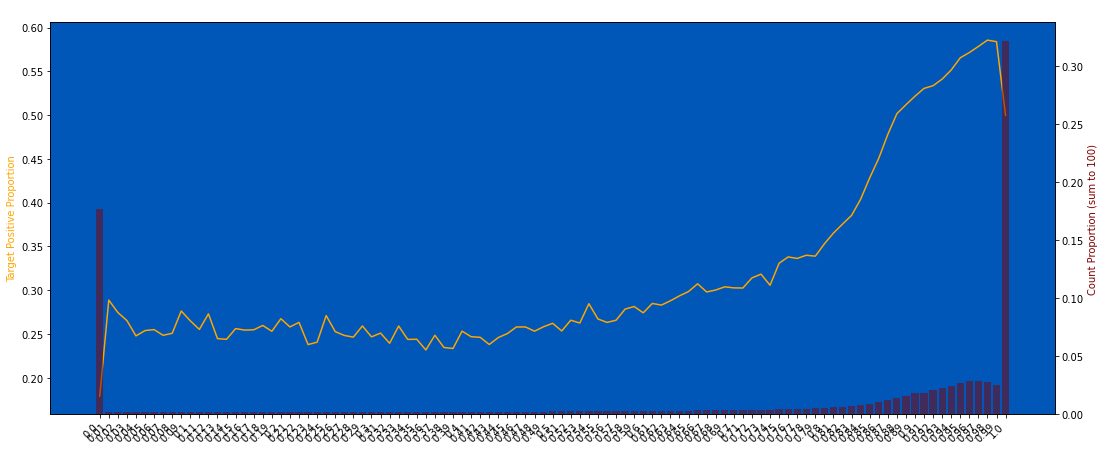

In [128]:
plot_target_check(train, "B_17", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [129]:
# plot_train_test_distribution(df_list, "B_17", nunique_thr=8000)

### B_18 (Done Integer)

In [130]:
# plot_target_check(train, "B_18", q=50, use_raw_bin=True)

In [131]:
%%time
df_list = round_dfs(df_list, col="B_18", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0036
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0033
CPU times: user 4.08 s, sys: 2.01 s, total: 6.09 s
Wall time: 8.08 s


In [132]:
for df in df_list:
    df["B_18"] = (df["B_18"] / 0.05).round(0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


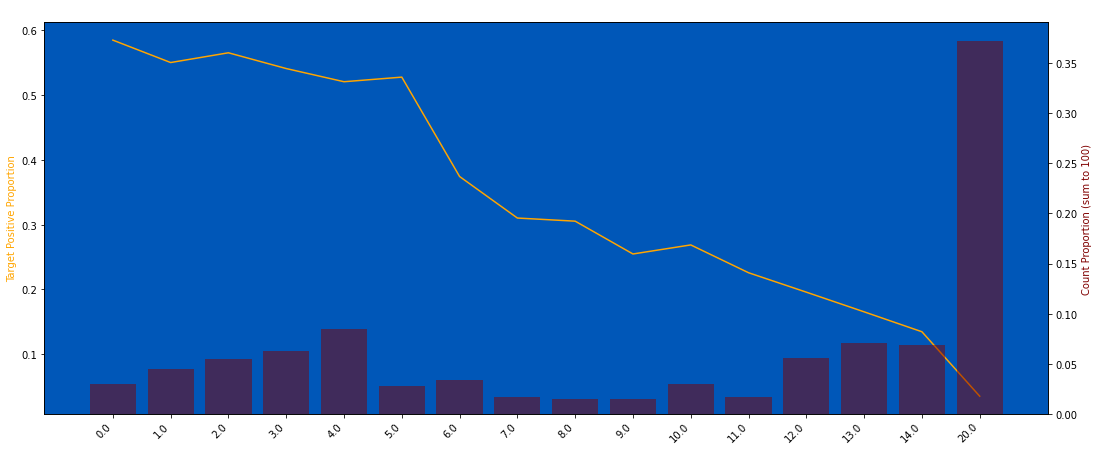

In [133]:
plot_target_check(train, "B_18", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [134]:
# plot_train_test_distribution(df_list, "B_18", nunique_thr=8000)

### B_19 (Done Integer)

In [135]:
# plot_target_check(train, "B_19", q=50, use_raw_bin=True)

In [136]:
%%time
df_list = round_dfs(df_list, col="B_19", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0023
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0022
CPU times: user 4.19 s, sys: 3.69 s, total: 7.88 s
Wall time: 11.8 s


In [137]:
# plot_target_check(train, "B_19", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [138]:
for df in df_list:
    df["B_19"] = (df["B_19"] / 0.0799)
df_list = round_dfs(df_list, col="B_19", decimals=0, add_new_col=False)

Before round, Train-Private PSI = 0.0022
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0008


2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


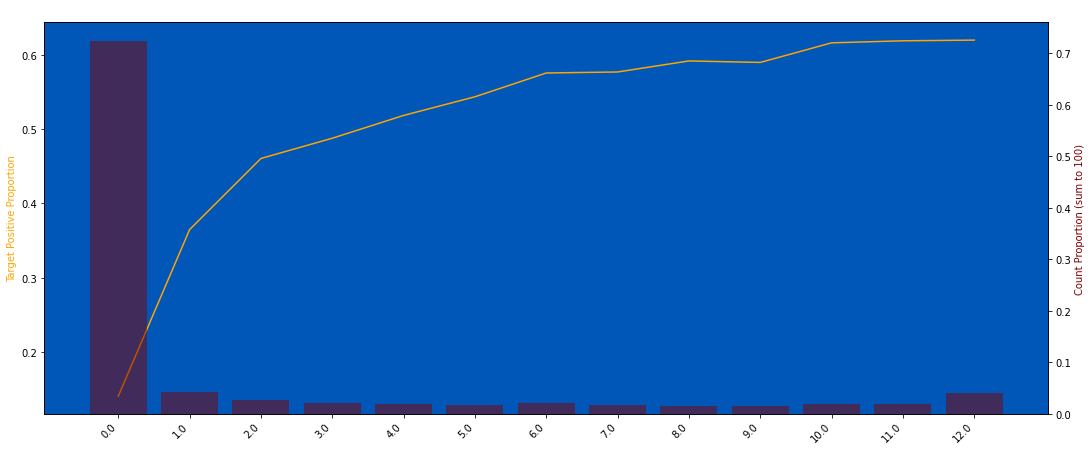

In [139]:
plot_target_check(train, "B_19", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [140]:
# plot_train_test_distribution(df_list, "B_19", nunique_thr=8000)

### B_20 (Done Integer)

In [141]:
# plot_target_check(train, "B_20", q=50, use_raw_bin=True)

In [142]:
%%time
df_list = round_dfs(df_list, col="B_20", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0026
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0025
CPU times: user 4.3 s, sys: 2 s, total: 6.3 s
Wall time: 8.24 s


In [143]:
# plot_target_check(train, "B_20", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [144]:
for df in df_list:
    df["B_20"] = (df["B_20"] / 0.06).round(0)

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


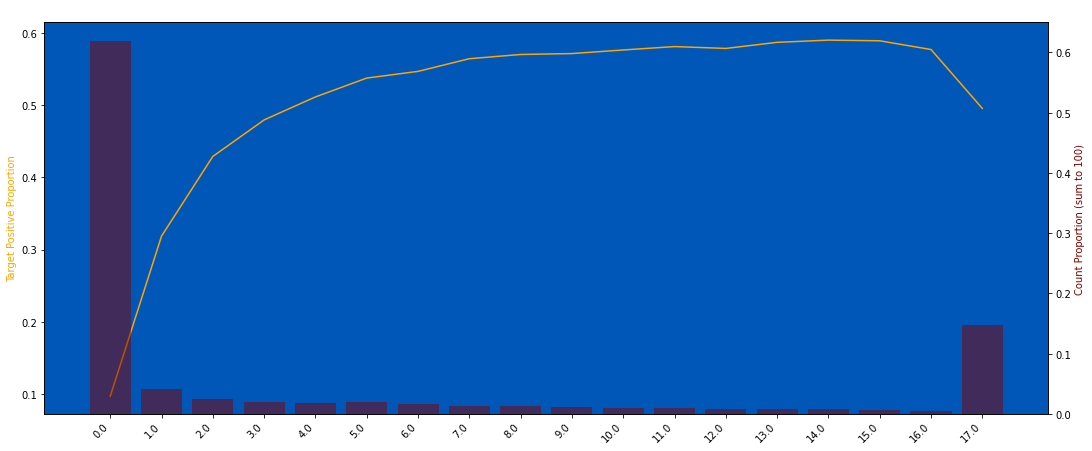

In [145]:
plot_target_check(train, "B_20", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [146]:
# plot_train_test_distribution(df_list, "B_20", nunique_thr=8000)

### B_21 (Done)

In [147]:
# plot_target_check(train, "B_21", q=50, use_raw_bin=True)

In [148]:
%%time
df_list = round_dfs(df_list, col="B_21", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0573
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0589
CPU times: user 4.04 s, sys: 1.84 s, total: 5.88 s
Wall time: 7.78 s


In [149]:
for df in df_list:
    df["B_21"] = ((df["B_21"] - 0.01) / 0.1)
df_list = round_dfs(df_list, col="B_21", decimals=0, add_new_col=False)

Before round, Train-Private PSI = 0.0589
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0518


In [150]:
for df in df_list:
    df["B_21"] = df["B_21"].replace(-1, np.nan)

In [151]:
print_percentile(df_list, "B_21", 99)
describe_all(df_list, "B_21")

99th percentile:
train : 195.0
public test : 194.0
private test : 197.0


,train,public test,private test
count,"111,795.0000","106,842.0000","94,282.0000"
mean,23.2104,21.7444,21.0802
std,44.8041,43.8587,45.5407
min,0.0000,0.0000,0.0000
25%,3.0000,2.0000,2.0000
50%,9.0000,9.0000,8.0000
75%,25.0000,24.0000,22.0000
max,"2,882.0000","2,002.0000","2,112.0000"
null_proportion,0.9798,0.9813,0.9833


In [152]:
for df in df_list:
    df = clip_col(df, "B_21", top_value=200, add_new_col=False)

5419656 null count, 0.980 null proportion
0.2390 of the targets have label = 1


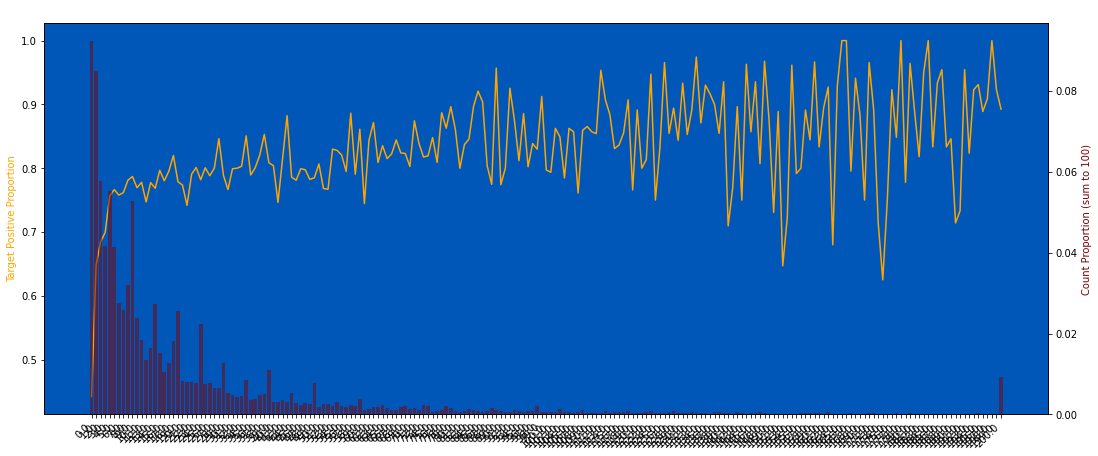

In [153]:
plot_target_check(train, "B_21", q=200, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

In [154]:
# plot_train_test_distribution(df_list, "B_21", nunique_thr=8000)

### B_22 (Done Integer)

In [155]:
# plot_target_check(train, "B_22", q=50, use_raw_bin=True, nunique_thr=7000)

In [156]:
%%time
df_list = round_dfs(df_list, col="B_22", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0015
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0003
CPU times: user 3.9 s, sys: 1.92 s, total: 5.82 s
Wall time: 7.89 s


In [157]:
for df in df_list:
    df["B_22"] *= 2

In [158]:
print_percentile(df_list, "B_22", 99.99)
describe_all(df_list, "B_22")

99.99th percentile:
train : 4.0
public test : 4.0
private test : 4.0


,train,public test,private test
count,"5,529,435.0000","5,717,907.0000","5,642,938.0000"
mean,0.2045,0.2180,0.2122
std,0.4465,0.4623,0.4577
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000
max,7.0000,7.0000,8.0000
null_proportion,0.0004,0.0003,0.0002


In [159]:
for df in df_list:
    df = clip_col(df, "B_22", top_value=4, add_new_col=False)

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


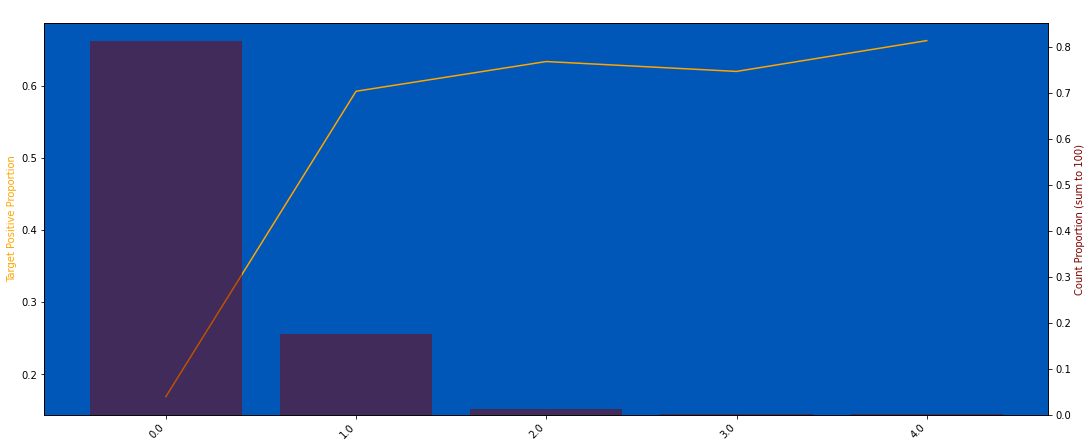

In [160]:
plot_target_check(train, "B_22", q=50, use_raw_bin=True, nunique_thr=7000, strfy_x=True, without_drop_tail=True)

In [161]:
# plot_train_test_distribution(df_list, "B_22", nunique_thr=8000, without_drop_tail=True)

### B_23 (Done)

In [162]:
# plot_target_check(train, "B_23", q=50, use_raw_bin=True)

In [163]:
%%time
df_list = round_dfs(df_list, col="B_23", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0181
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0065
CPU times: user 3.92 s, sys: 1.65 s, total: 5.57 s
Wall time: 7.43 s


In [164]:
print_percentile(df_list, "B_23", 99.99)
describe_all(df_list, "B_23")

99.99th percentile:
train : 1.38
public test : 1.37
private test : 1.37


,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.1665,0.1666,0.1613
std,0.2294,0.2276,0.2244
min,0.0000,0.0000,0.0000
25%,0.0100,0.0100,0.0100
50%,0.0500,0.0600,0.0500
75%,0.2400,0.2400,0.2300
max,1.6900,1.5900,1.6700
null_proportion,0.0000,0.0000,0.0000


In [165]:
for df in df_list:
    df = clip_col(df, "B_23", top_value=1.37, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


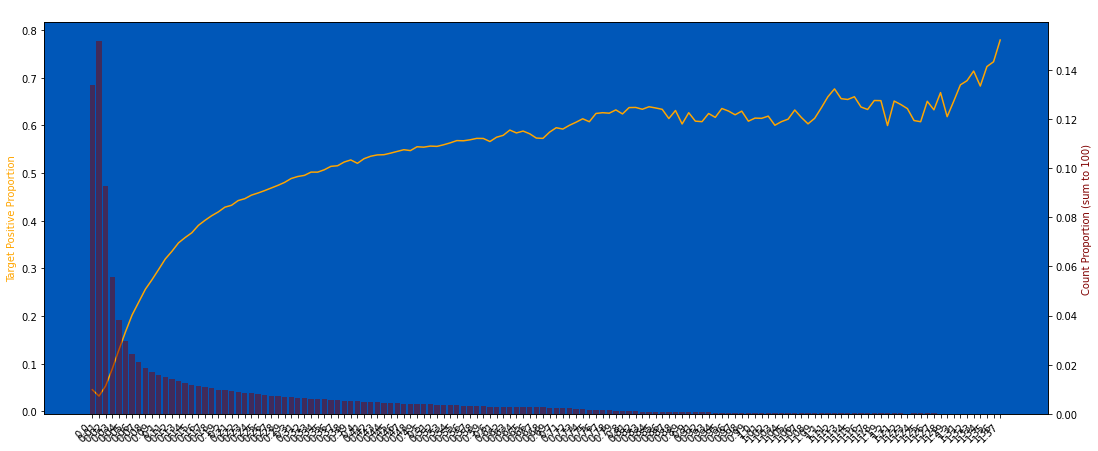

In [166]:
plot_target_check(train, "B_23", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [167]:
# plot_train_test_distribution(df_list, "B_23", nunique_thr=5000, without_drop_tail=True)

### B_24 (Done)

In [168]:
# plot_target_check(train, "B_24", q=50, use_raw_bin=True)

In [169]:
%%time
df_list = round_dfs(df_list, col="B_24", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0775
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0757
CPU times: user 3.6 s, sys: 1.64 s, total: 5.24 s
Wall time: 7.03 s


In [170]:
for df in df_list:
    df["B_24"] = (df["B_24"] / 0.05).round(0)
    df["B_24"] = df["B_24"].replace(0, np.nan)

In [171]:
print_percentile(df_list, "B_24", 99.6)
describe_all(df_list, "B_24")

99.6th percentile:
train : 185.0
public test : 198.0
private test : 195.0


,train,public test,private test
count,"187,235.0000","218,942.0000","220,727.0000"
mean,20.4767,21.7314,21.8214
std,28.0004,30.4286,29.5900
min,1.0000,1.0000,1.0000
25%,7.0000,7.0000,7.0000
50%,12.0000,12.0000,12.0000
75%,23.0000,24.0000,25.0000
max,932.0000,"1,474.0000",879.0000
null_proportion,0.9662,0.9617,0.9609


In [172]:
for df in df_list:
    df = clip_col(df, "B_24", top_value=200, add_new_col=False)

5344216 null count, 0.966 null proportion
0.2381 of the targets have label = 1


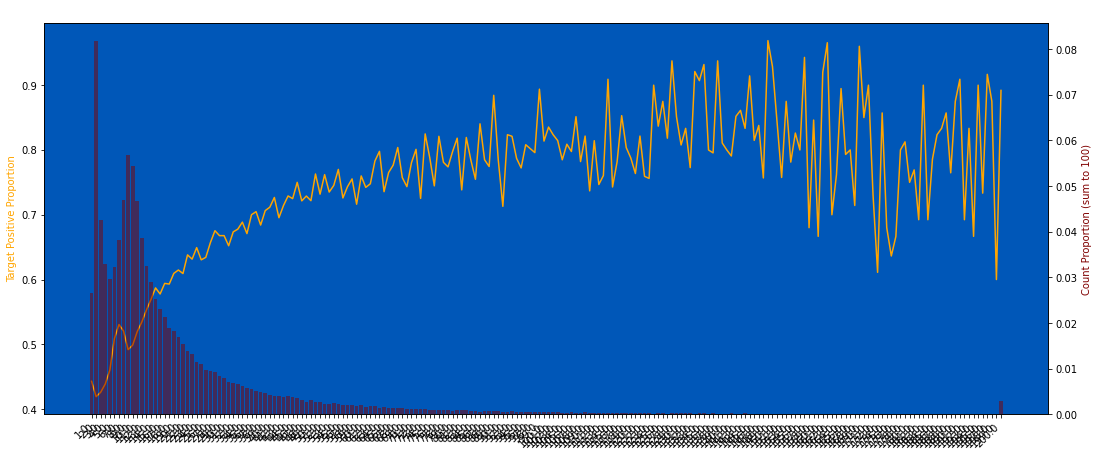

In [173]:
plot_target_check(train, "B_24", q=200, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [174]:
# plot_train_test_distribution(df_list, "B_24", nunique_thr=8000)

### B_25 (Done)

In [175]:
# plot_target_check(train, "B_25", q=50, use_raw_bin=True)

In [176]:
%%time
df_list = round_dfs(df_list, col="B_25", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0663
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0706
CPU times: user 3.75 s, sys: 1.65 s, total: 5.4 s
Wall time: 7.14 s


In [177]:
print_percentile(df_list, "B_25", 99.9)
describe_all(df_list, "B_25")

99.9th percentile:
train : 1.94
public test : 2.03
private test : 2.08


,train,public test,private test
count,"5,524,528.0000","5,710,673.0000","5,638,316.0000"
mean,0.0989,0.1108,0.1122
std,0.2087,0.2249,0.2304
min,-11.2600,-4.7500,-4.2700
25%,0.0000,0.0000,0.0000
50%,0.0100,0.0200,0.0200
75%,0.1000,0.1200,0.1200
max,15.6900,21.6400,41.7000
null_proportion,0.0013,0.0015,0.0011


In [178]:
for df in df_list:
    df = clip_col(df, "B_25", top_value=2, add_new_col=False)
    df = clip_col(df, "B_25", btm_value=-0.1, add_new_col=False)

6923 null count, 0.001 null proportion
0.0858 of the targets have label = 1


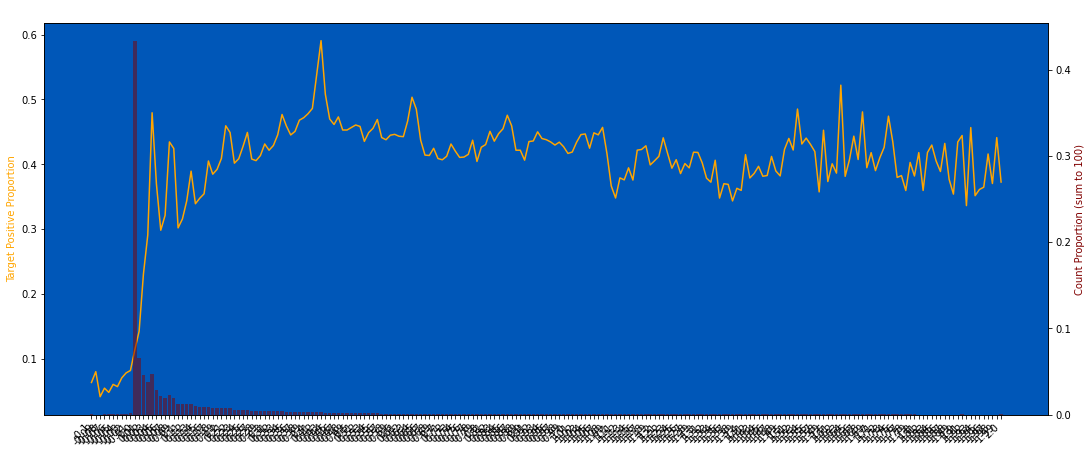

In [179]:
plot_target_check(train, "B_25", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [180]:
# plot_train_test_distribution(df_list, "B_25", nunique_thr=8000)

### B_26 (Done)

In [181]:
# plot_target_check(train, "B_26", q=50, use_raw_bin=True)

In [182]:
%%time
df_list = round_dfs(df_list, col="B_26", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0622
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0622
CPU times: user 3.58 s, sys: 1.63 s, total: 5.21 s
Wall time: 6.93 s


In [183]:
for df in df_list:
    df["B_26"] = df["B_26"].replace(0, np.nan)

In [184]:
print_percentile(df_list, "B_26", 95)
describe_all(df_list, "B_26")

95th percentile:
train : 7.0
public test : 6.62
private test : 7.48


,train,public test,private test
count,"250,153.0000","250,613.0000","245,415.0000"
mean,1.8926,1.8318,2.0300
std,12.0272,10.4051,11.2642
min,0.0100,0.0100,0.0100
25%,0.0700,0.0700,0.0700
50%,0.2000,0.2000,0.2100
75%,0.7900,0.7500,0.8300
max,"1,499.2200","1,033.2500",772.7400
null_proportion,0.9548,0.9562,0.9565


In [185]:
for df in df_list:
    df = clip_col(df, "B_26", top_value=7, add_new_col=False)
    # df["B_26"] = df["B_26"].replace(0.01, np.nan)

5281298 null count, 0.955 null proportion
0.2316 of the targets have label = 1


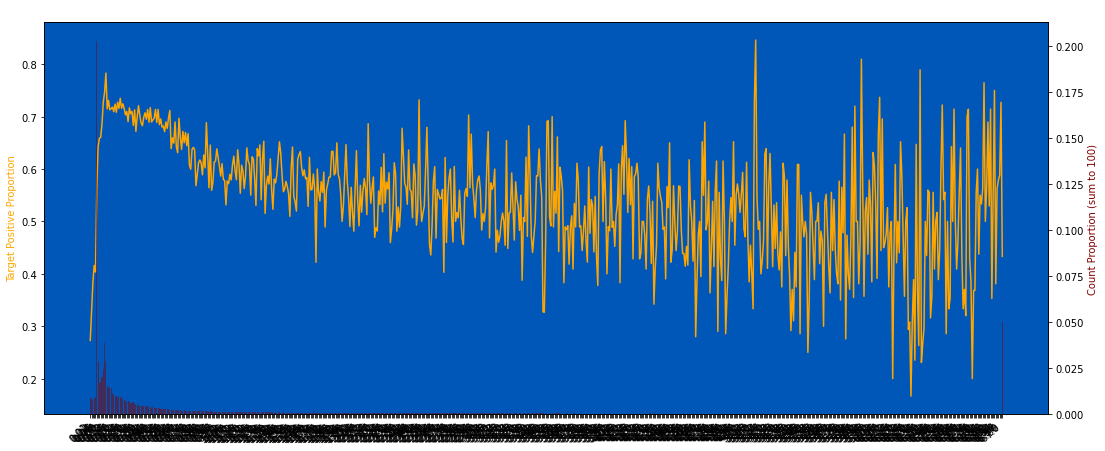

In [186]:
plot_target_check(train, "B_26", q=100, use_raw_bin=True, nunique_thr=35000, strfy_x=True, without_drop_tail=True)

In [187]:
# plot_train_test_distribution(df_list, "B_26", nunique_thr=8000, without_drop_tail=True)

### B_27 (Done Binary)

In [188]:
# plot_target_check(train, "B_27", q=50, use_raw_bin=True)

In [189]:
%%time
df_list = round_dfs(df_list, col="B_27", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0425
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0096
CPU times: user 3.64 s, sys: 1.61 s, total: 5.25 s
Wall time: 6.98 s


In [190]:
# plot_target_check(train, "B_27", q=500, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [191]:
for df in df_list:
    df["B_27"] = np.where(df["B_27"] > 0, 1, 0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


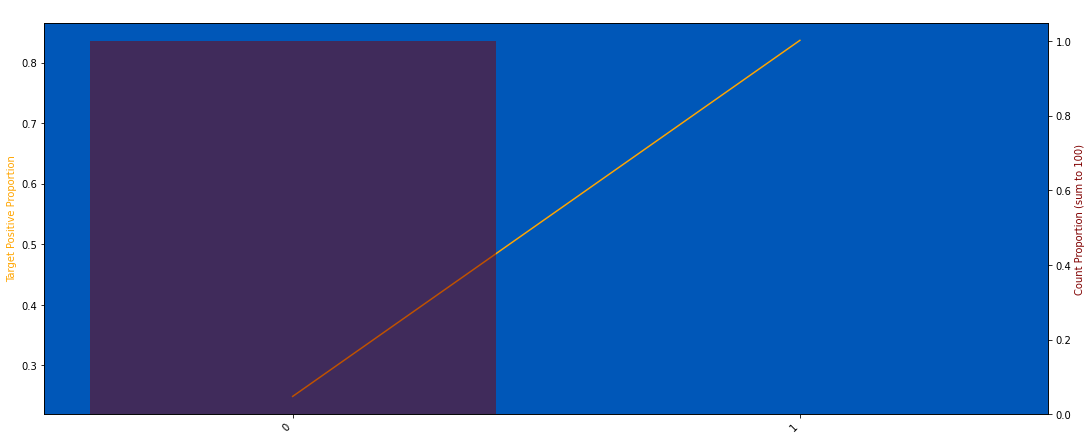

In [192]:
plot_target_check(train, "B_27", q=500, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [193]:
# plot_train_test_distribution(df_list, "B_27", nunique_thr=8000, without_drop_tail=True)

### B_28 (Done)

In [194]:
# plot_target_check(train, "B_28", q=50, use_raw_bin=True)

In [195]:
%%time
df_list = round_dfs(df_list, col="B_28", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0822
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0781
CPU times: user 3.74 s, sys: 1.62 s, total: 5.36 s
Wall time: 7.14 s


In [196]:
print_percentile(df_list, "B_28", 99.9)
describe_all(df_list, "B_28")

99.9th percentile:
train : 1.93
public test : 2.01
private test : 2.06


,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.1495,0.1567,0.1578
std,0.2275,0.2318,0.2349
min,-0.0100,-0.0100,-0.0100
25%,0.0200,0.0200,0.0200
50%,0.0700,0.0800,0.0800
75%,0.1900,0.2000,0.2000
max,25.5300,28.0200,15.1700
null_proportion,0.0000,0.0000,0.0000


In [197]:
for df in df_list:
    df = clip_col(df, "B_28", top_value=2, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


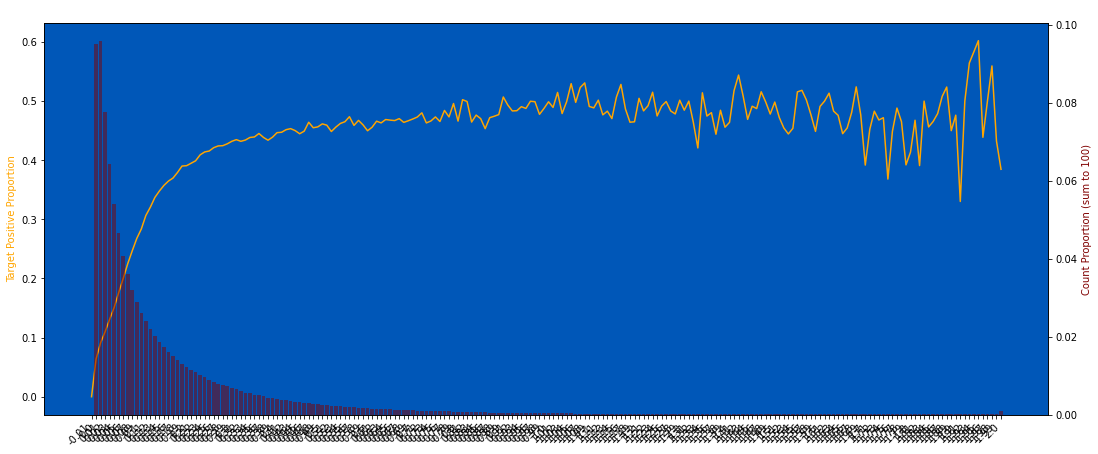

In [198]:
plot_target_check(train, "B_28", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [199]:
# plot_train_test_distribution(df_list, "B_28", nunique_thr=8000, without_drop_tail=True)

### B_29 (Drop due to null count drift)

In [200]:
# plot_target_check(train, "B_29", q=50, use_raw_bin=True)

In [201]:
# df_list = round_dfs(df_list, col="B_29", decimals=2, add_new_col=False)

In [202]:
# describe_all(df_list, "B_29")

In [203]:
# plot_target_check(train, "B_29", q=150, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [204]:
# plot_train_test_distribution(df_list, "B_29", nunique_thr=8000)

In [205]:
for df in df_list:
    df.drop(columns="B_29", errors="ignore", inplace=True)

### B_30 (Done Category)

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


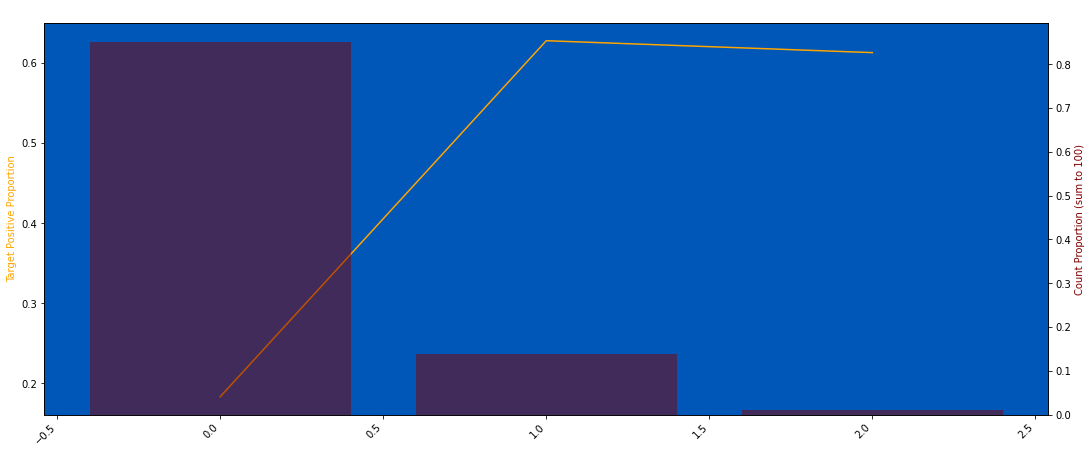

In [206]:
plot_target_check(train, "B_30", q=50, use_raw_bin=True, without_drop_tail=True)

In [207]:
# plot_train_test_distribution(df_list, "B_30", nunique_thr=8000, without_drop_tail=True)

### B_31 (Done Binary)

In [208]:
print_percentile(df_list, "B_31", 99.9)
describe_all(df_list, "B_31")

99.9th percentile:
train : 1.0
public test : 1.0
private test : 1.0


,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.9969,0.9966,0.9965
std,0.0552,0.0580,0.0593
min,0.0000,0.0000,0.0000
25%,1.0000,1.0000,1.0000
50%,1.0000,1.0000,1.0000
75%,1.0000,1.0000,1.0000
max,1.0000,1.0000,1.0000
null_proportion,0.0000,0.0000,0.0000


0 null count, 0.000 null proportion
nan of the targets have label = 1


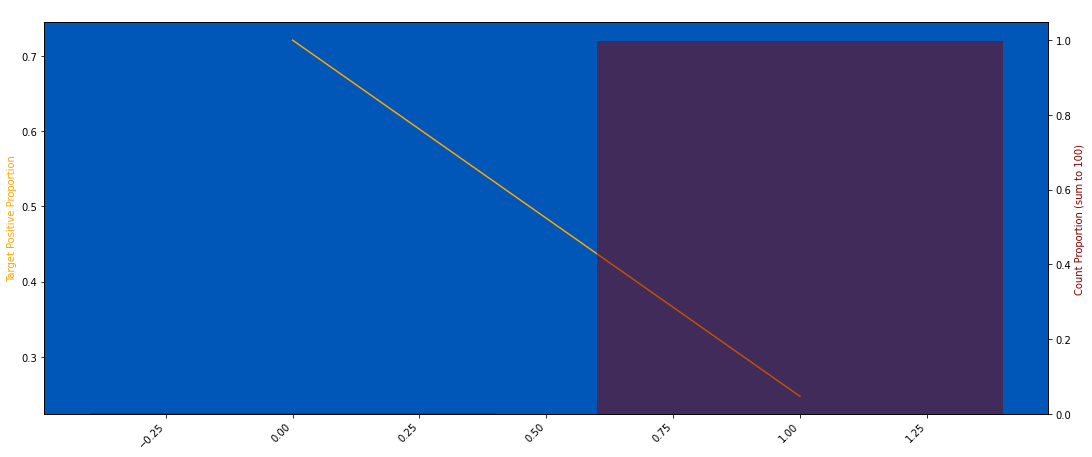

In [209]:
plot_target_check(train, "B_31", q=50, use_raw_bin=True, nunique_thr=3, without_drop_tail=True)

In [210]:
# plot_train_test_distribution(df_list, "B_31", nunique_thr=8000, without_drop_tail=True)

### B_32 (Done Binary)

In [211]:
# plot_target_check(train, "B_32", q=50, use_raw_bin=True)

In [212]:
%%time
df_list = round_dfs(df_list, col="B_32", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0010
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0010
CPU times: user 4.53 s, sys: 5.46 s, total: 9.99 s
Wall time: 14.3 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


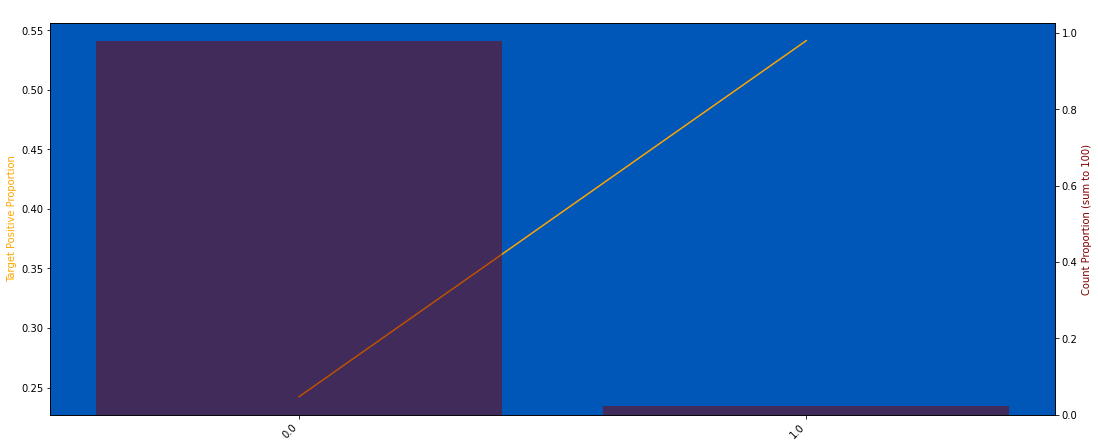

In [213]:
plot_target_check(train, "B_32", q=50, use_raw_bin=True, nunique_thr=50000, strfy_x=True, without_drop_tail=True)

In [214]:
# plot_train_test_distribution(df_list, "B_32", nunique_thr=8000, without_drop_tail=True)

### B_33 (Done Binary)

In [215]:
# plot_target_check(train, "B_33", q=50, use_raw_bin=True)

In [216]:
%%time
df_list = round_dfs(df_list, col="B_33", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0006
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0006
CPU times: user 5.13 s, sys: 9.13 s, total: 14.3 s
Wall time: 20.8 s


2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


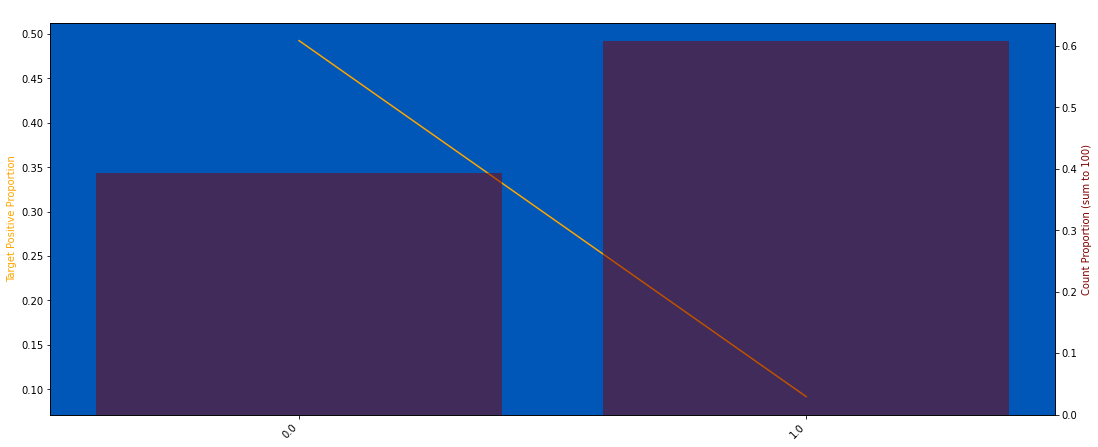

In [217]:
plot_target_check(train, "B_33", q=50, use_raw_bin=True, nunique_thr=50000, strfy_x=True, without_drop_tail=True)

In [218]:
# plot_train_test_distribution(df_list, "B_33", nunique_thr=8000, without_drop_tail=True)

### B_36 (Done)

In [219]:
# plot_target_check(train, "B_36", q=50, use_raw_bin=True)

In [220]:
%%time
df_list = round_dfs(df_list, col="B_36", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1501
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0166
CPU times: user 4.21 s, sys: 2.3 s, total: 6.51 s
Wall time: 8.25 s


In [221]:
print_percentile(df_list, "B_36", 99.99)
describe_all(df_list, "B_36")

99.99th percentile:
train : 0.51
public test : 0.6505319999903441
private test : 0.72


,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.0014,0.0022,0.0023
std,0.0210,0.0264,0.0274
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000
max,1.0000,0.8300,1.1600
null_proportion,0.0000,0.0000,0.0000


In [222]:
for df in df_list:
    df = clip_col(df, "B_36", top_value=0.5, add_new_col=False)

In [223]:
for df in df_list:
    df["B_36"] = df["B_36"].replace(0, np.nan)

5500924 null count, 0.994 null proportion
0.2474 of the targets have label = 1


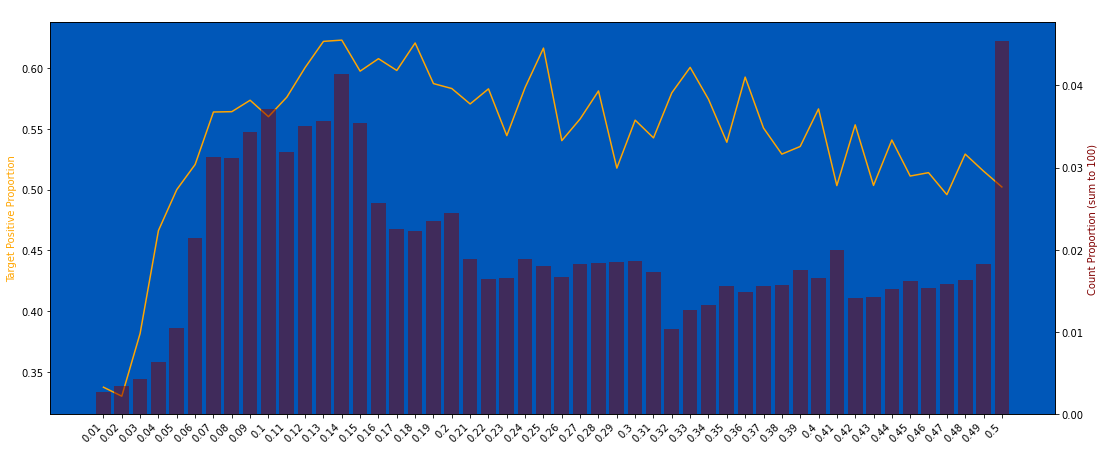

In [224]:
plot_target_check(train, "B_36", q=100, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [225]:
# plot_target_check(train, "B_36", q=100, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [226]:
# plot_train_test_distribution(df_list, "B_36", nunique_thr=8000, without_drop_tail=True)

In [227]:
gc.collect()

30478

### B_37 (Done)

In [228]:
# plot_target_check(train, "B_37", q=50, use_raw_bin=True)

In [229]:
%%time
df_list = round_dfs(df_list, col="B_37", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0644
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0625
CPU times: user 4.47 s, sys: 2.61 s, total: 7.08 s
Wall time: 8.98 s


In [230]:
print_percentile(df_list, "B_37", 0.03)
describe_all(df_list, "B_37")

0.03th percentile:
train : -0.07
public test : -0.1
private test : -0.1


,train,public test,private test
count,"5,531,395.0000","5,718,424.0000","5,643,318.0000"
mean,0.1182,0.1242,0.1198
std,0.2118,0.2164,0.2099
min,-7.6100,-7.0800,-4.2400
25%,0.0000,0.0000,0.0000
50%,0.0300,0.0300,0.0300
75%,0.1200,0.1300,0.1200
max,1.3200,1.3200,1.3200
null_proportion,0.0000,0.0002,0.0002


In [231]:
for df in df_list:
    df = clip_col(df, "B_37", btm_value=-0.1, add_new_col=False)

56 null count, 0.000 null proportion
0.1964 of the targets have label = 1


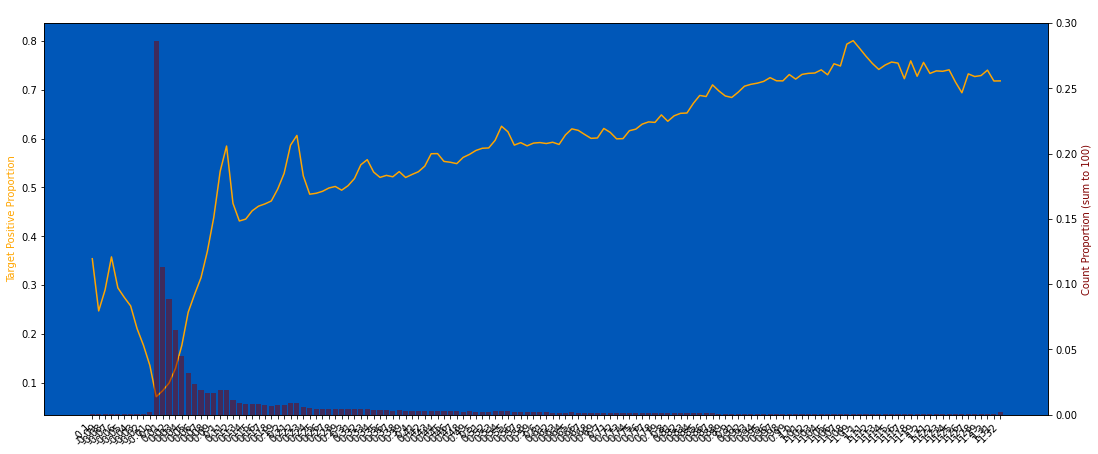

In [232]:
plot_target_check(train, "B_37", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

### B_38 (Done Category)

In [233]:
for df in df_list:
    print(sorted(df["B_38"].unique()))

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]


In [234]:
mapping = dict(train.groupby(["B_38"])["target"].mean())
mapping

{1.0: 0.13526434704800755,
 2.0: 0.0633063558246025,
 3.0: 0.32860357758809544,
 4.0: 0.6997155131782841,
 5.0: 0.5594304673871995,
 6.0: 0.6149160701061467,
 7.0: 0.49886498756891146}

In [235]:
for df in df_list:
    df["B_38"] = df["B_38"].map(mapping)
    df["B_38"] = df["B_38"].astype("category").cat.codes
    df["B_38"] = df["B_38"].replace(-1, 0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


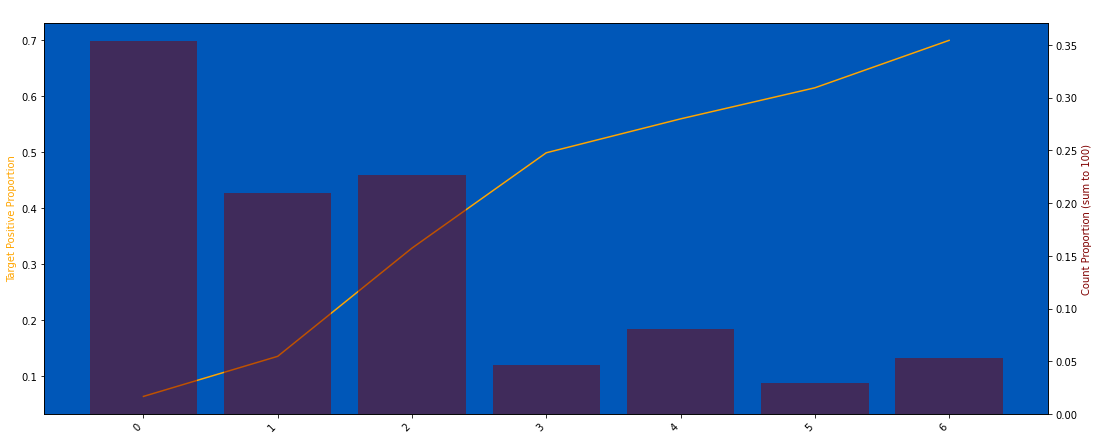

In [236]:
plot_target_check(train, "B_38", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [237]:
# plot_train_test_distribution(df_list, "B_38", nunique_thr=1000, without_drop_tail=True)

### B_39 (Done Drop)

In [238]:
# plot_target_check(train, "B_39", q=50, use_raw_bin=True)

In [239]:
%%time
df_list = round_dfs(df_list, col="B_39", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0367
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0268
CPU times: user 3.2 s, sys: 2.14 s, total: 5.34 s
Wall time: 7.52 s


In [240]:
print_percentile(df_list, "B_39", 99.9)
describe_all(df_list, "B_39")

99.9th percentile:
train : 1.02
public test : 1.0
private test : 1.0


,train,public test,private test
count,"33,632.0000","69,099.0000","68,492.0000"
mean,0.2505,0.4339,0.4285
std,0.2979,0.3419,0.3225
min,-0.9800,-0.0300,-0.1500
25%,0.0500,0.1500,0.1600
50%,0.1400,0.3400,0.3600
75%,0.2900,0.6700,0.6400
max,2.0600,2.8100,2.0500
null_proportion,0.9939,0.9879,0.9879


In [241]:
for df in df_list:
    df = clip_col(df, "B_39", top_value=1, add_new_col=False)

In [242]:
# plot_target_check(train, "B_39", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Train-Public PSI: 0.0160, Train-Private PSI: 0.0213
Bottom 1% and Top 1% are dropped from this chart


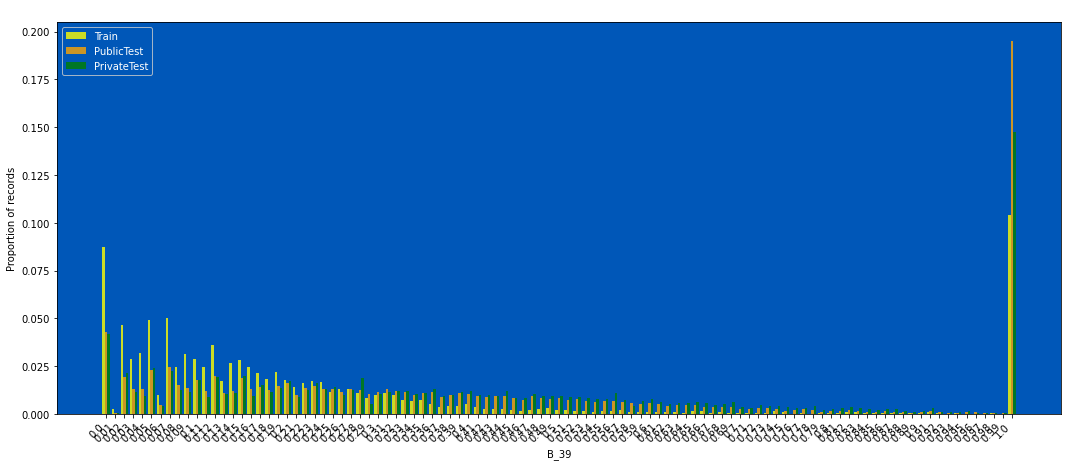

In [243]:
plot_train_test_distribution(df_list, "B_39", nunique_thr=1000)

In [244]:
for df in df_list:
    df.drop(columns=["B_39"], errors="ignore", inplace=True)

### B_40 (Done)

In [245]:
# plot_target_check(train, "B_40", q=50, use_raw_bin=True)

In [246]:
%%time
df_list = round_dfs(df_list, col="B_40", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0444
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0444
CPU times: user 4.59 s, sys: 2.91 s, total: 7.5 s
Wall time: 9.65 s


In [247]:
print_percentile(df_list, "B_40", 99)
describe_all(df_list, "B_40")

99th percentile:
train : 1.0
public test : 0.97
private test : 0.97


,train,public test,private test
count,"5,531,398.0000","5,718,434.0000","5,643,325.0000"
mean,0.1983,0.1755,0.1821
std,8.0813,1.9339,3.7807
min,0.0000,0.0000,0.0000
25%,0.0100,0.0100,0.0100
50%,0.0500,0.0500,0.0500
75%,0.2400,0.2400,0.2300
max,"5,755.0700","2,664.2400","2,500.4800"
null_proportion,0.0000,0.0002,0.0002


In [248]:
for df in df_list:
    df = clip_col(df, "B_40", top_value=1, add_new_col=False)

53 null count, 0.000 null proportion
0.1698 of the targets have label = 1


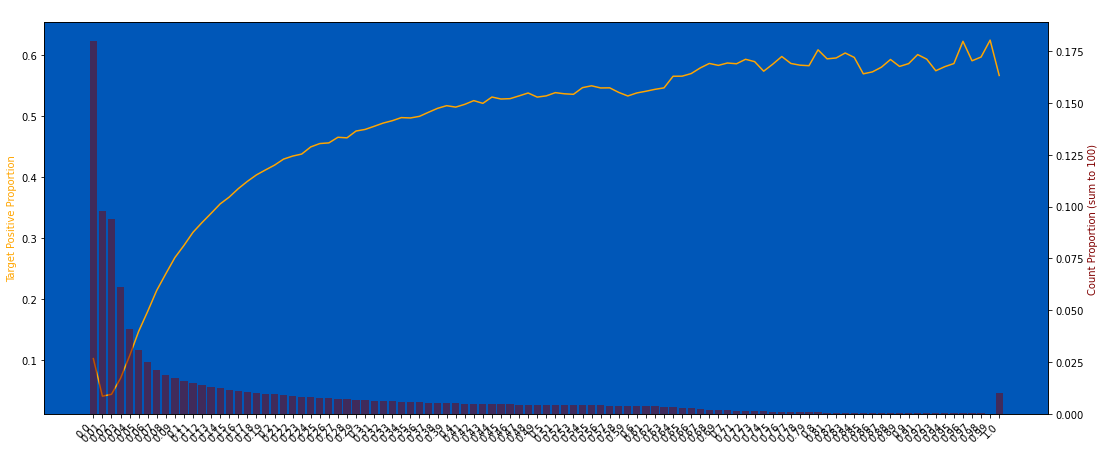

In [249]:
plot_target_check(train, "B_40", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [250]:
# plot_train_test_distribution(df_list, "B_40", nunique_thr=5000)

### B_41

In [251]:
# plot_target_check(train, "B_41", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

In [252]:
%%time
df_list = round_dfs(df_list, col="B_41", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0024
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0018
CPU times: user 4.35 s, sys: 3.36 s, total: 7.72 s
Wall time: 10 s


In [253]:
print_percentile(df_list, "B_41", 99.9)
describe_all(df_list, "B_41")

99.9th percentile:
train : 3.0
public test : 3.0
private test : 3.0


,train,public test,private test
count,"5,530,761.0000","5,717,254.0000","5,642,742.0000"
mean,0.0273,0.0309,0.0316
std,0.2223,0.2471,0.2419
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000
max,22.0000,32.0000,24.0000
null_proportion,0.0001,0.0004,0.0003


In [254]:
for df in df_list:
    df = clip_col(df, "B_41", top_value=2, add_new_col=False)

690 null count, 0.000 null proportion
0.1420 of the targets have label = 1


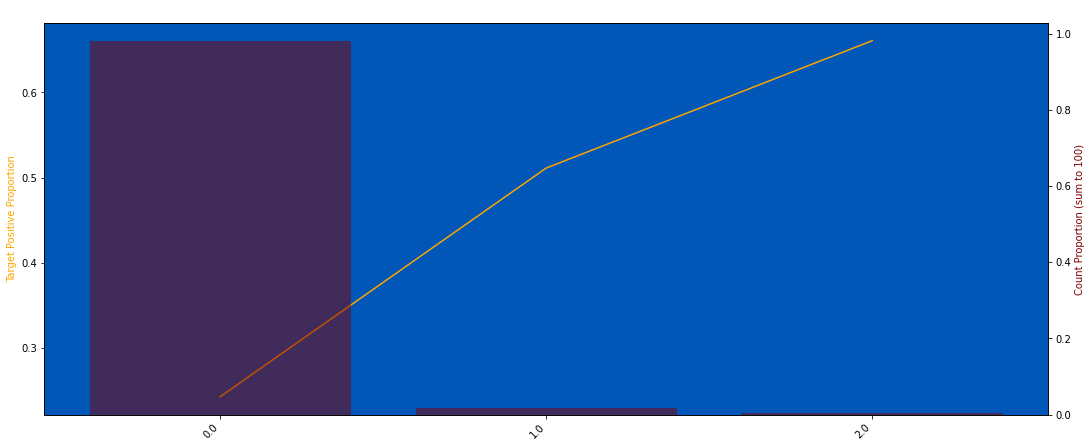

In [255]:
plot_target_check(train, "B_41", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [256]:
# plot_train_test_distribution(df_list, "B_41", nunique_thr=100, without_drop_tail=True)

### B_42

In [257]:
# plot_target_check(train, "B_42", q=50, use_raw_bin=True)

In [258]:
%%time
df_list = round_dfs(df_list, col="B_42", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1140
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.1099
CPU times: user 3.33 s, sys: 3.24 s, total: 6.57 s
Wall time: 9.15 s


In [259]:
print_percentile(df_list, "B_42", 99)
describe_all(df_list, "B_42")

99th percentile:
train : 1.0
public test : 0.9
private test : 0.91


,train,public test,private test
count,"71,478.0000","92,388.0000","108,930.0000"
mean,0.1050,0.0947,0.0925
std,0.3137,0.2677,0.2344
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0200,0.0200,0.0200
75%,0.1000,0.0900,0.0900
max,9.0500,12.1900,7.0500
null_proportion,0.9871,0.9838,0.9807


In [260]:
for df in df_list:
    df = clip_col(df, "B_42", top_value=1, add_new_col=False)

5459973 null count, 0.987 null proportion
0.2508 of the targets have label = 1


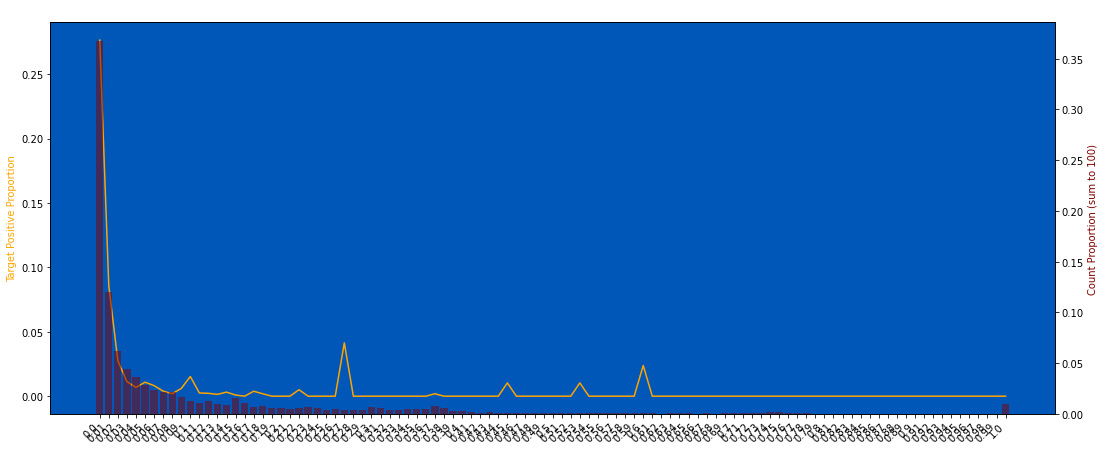

In [261]:
plot_target_check(train, "B_42", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [262]:
# plot_train_test_distribution(df_list, "B_42", nunique_thr=300)

### Column checking

In [263]:
all_columns = get_cols(df_list[0], ["B_"])
print(all_columns)

['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_27', 'B_28', 'B_30', 'B_31', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_40', 'B_41', 'B_42', 'B_723', 'B_111', 'B_137']


In [264]:
d_col_nunique = df_list[0][all_columns].nunique()
less_unique_d_cols = d_col_nunique[d_col_nunique < 200].index.tolist()

In [265]:
print(less_unique_d_cols)

['B_1', 'B_2', 'B_3', 'B_4', 'B_7', 'B_8', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_22', 'B_23', 'B_27', 'B_30', 'B_31', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_40', 'B_41', 'B_42', 'B_111', 'B_137']


In [266]:
for col in less_unique_d_cols:
    temp = integerize(train[col])
    if (temp - train[col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to integer")
        for df in df_list:
            df[col] = integerize(df[col])

B_8 fulfill criteria to convert to integer
B_16 fulfill criteria to convert to integer
B_18 fulfill criteria to convert to integer
B_19 fulfill criteria to convert to integer
B_20 fulfill criteria to convert to integer
B_22 fulfill criteria to convert to integer
B_27 fulfill criteria to convert to integer
B_30 fulfill criteria to convert to integer
B_31 fulfill criteria to convert to integer
B_32 fulfill criteria to convert to integer
B_33 fulfill criteria to convert to integer
B_38 fulfill criteria to convert to integer
B_41 fulfill criteria to convert to integer


In [267]:
float64_columns = train.select_dtypes("float64").columns.tolist()
for col in float64_columns:
    temp = df_list[-1][col].astype(np.float32).values
    if (temp - df_list[-1][col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to float32")
        for df in df_list:
            df[col] = df[col].astype(np.float32)

B_1 fulfill criteria to convert to float32
B_2 fulfill criteria to convert to float32
B_3 fulfill criteria to convert to float32
B_4 fulfill criteria to convert to float32
B_5 fulfill criteria to convert to float32
B_6 fulfill criteria to convert to float32
B_7 fulfill criteria to convert to float32
B_9 fulfill criteria to convert to float32
B_10 fulfill criteria to convert to float32
B_11 fulfill criteria to convert to float32
B_12 fulfill criteria to convert to float32
B_13 fulfill criteria to convert to float32
B_14 fulfill criteria to convert to float32
B_15 fulfill criteria to convert to float32
B_17 fulfill criteria to convert to float32
B_21 fulfill criteria to convert to float32
B_23 fulfill criteria to convert to float32
B_24 fulfill criteria to convert to float32
B_25 fulfill criteria to convert to float32
B_26 fulfill criteria to convert to float32
B_28 fulfill criteria to convert to float32
B_36 fulfill criteria to convert to float32
B_37 fulfill criteria to convert to floa

In [268]:
no_use_features = ["temp"] + df_list[0].columns[df_list[0].columns.str.endswith("_")].tolist()
no_use_features

['temp']

In [269]:
%%time
for df in tqdm(df_list):
    df.drop(columns=no_use_features, errors="ignore", inplace=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.09s/it]

CPU times: user 2.93 s, sys: 3.04 s, total: 5.98 s
Wall time: 6.33 s


### Verify if all columns have been clipped

In [270]:
for col in tqdm(df_list[0].columns):
    if col in NON_FEATURE_COLUMNS:
        continue
    if not (df_list[0][col].min() == df_list[1][col].min() == df_list[2][col].min()):
        print(f"Min of column {col} is different: {df_list[0][col].min()}, {df_list[1][col].min()}, {df_list[2][col].min()}")
    
    if not (df_list[0][col].max() == df_list[1][col].max() == df_list[2][col].max()):
        print(f"Max of column {col} is different: {df_list[0][col].max()}, {df_list[1][col].max()}, {df_list[2][col].max()}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 20.28it/s]


In [271]:
%%time
train = df_list[0]
test = pd.concat(df_list[1:], axis=0)
test = test.sort_values(by=["customer_ID", "S_2"]).reset_index(drop=True)

CPU times: user 10.7 s, sys: 6.58 s, total: 17.2 s
Wall time: 18.8 s


In [272]:
train.shape, test.shape

((5531451, 46), (11363762, 45))

In [273]:
sys.getsizeof(train) / 1e9, sys.getsizeof(test) / 1e9

(1.797721591, 3.511402602)

In [274]:
%%time
train.to_parquet(f"./train_parquet/train_balance_.parquet")
test.to_parquet(f"./test_parquet/test_balance_.parquet")

CPU times: user 18.8 s, sys: 3.14 s, total: 22 s
Wall time: 19.5 s


In [275]:
END = time.time()

In [276]:
print(f"{END - START:.2f} seconds elapsed")

924.28 seconds elapsed


### B_2

In [277]:
# plot_heatmap(train_corr.loc[["B_2"], :], annot=True, fmt=".2f", figsize=(25, 1))

In [278]:
def get_weird_cid_list(df):
    b2_check_df = df.groupby("customer_ID")["B_2"].agg(["max", "min", "mean", "std"]).reset_index()
    b2_check_df["range"] = (b2_check_df["max"] - b2_check_df["min"]).round(2)
    sozi_cid_list = b2_check_df.loc[(b2_check_df["range"].isin([0, 0.19])) | (b2_check_df["min"].isin([0.81, 1]))].customer_ID.tolist()
    sozi_cid_list2 = b2_check_df.loc[(b2_check_df["range"].isin([0.81, 1]))].customer_ID.tolist()
    sozi_cid_list3 = b2_check_df.loc[(b2_check_df["max"] == 0.81) & (~b2_check_df["std"].between(0.15, 0.3))].customer_ID.tolist()
    sozi_cid_list4 = b2_check_df.loc[(b2_check_df["max"] == 1) & (~b2_check_df["std"].between(0.15, 0.49))].customer_ID.tolist()
    final_list = sozi_cid_list + sozi_cid_list2 + sozi_cid_list3 #+ sozi_cid_list4
    return final_list, b2_check_df

In [279]:
_, b2_check_df = get_weird_cid_list(train)

In [280]:
# plot_scatterplot(b2_check_df, "max", "std")

In [281]:
for df in tqdm(df_list):
    sozi_cid_list, _ = get_weird_cid_list(df)
    df.loc[(df["customer_ID"].isin(sozi_cid_list)) & (df["B_2"].isin([0.81, 1])), "B_2"] = 1.05

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.91s/it]
